# Gaussian Process Analysis Notebook for Policy Function

## Recreates analysis and figures (1C, 1D, 2, 3, 4) corresponding to the policy function.

#### Note that these plots correspond to Gaussian Processes that were trained individually for each subject

In [1]:
#Import necessary packages
import sys
import csv
import numpy as np
import gpflow
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.cluster.vq import kmeans
tf.set_random_seed(1234)
import pickle
from sklearn.metrics import roc_curve,auc
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
ps_colors = ['#EFEFEF', '#EC4941', '#25A7DD','#060101']
import seaborn as sns
from scipy import stats
from scipy.stats import ncx2,pearsonr
import matplotlib.patches as patches
import warnings
warnings.filterwarnings("ignore")
import matplotlib.ticker as MT
import matplotlib.lines as L
import matplotlib.cm as CM
import matplotlib.colors as C
import matplotlib.pyplot as P
import PKutils
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss

/home/krm58/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
def calculateprobitp(subID):
    
    inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
    m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
        
    probitp = []
    varsp = []
    Xfeatures_totaldata = np.array(inputdata, dtype=float)    
    dataset = tf.data.Dataset.from_tensor_slices(Xfeatures_totaldata)
    dataset = dataset.batch(len(inputdata))
    iterator = dataset.make_one_shot_iterator()
    data = iterator.get_next()
    m.initialize()   

    with tf.Session() as sess:
        mu, var = m.predict_f(data.eval())
        probitp.append(mu)    
        varsp.append(var)
    return probitp, varsp

### Make Figure 2

In [3]:
#Calculate AUC for each subject's policy model, takes roughly 5-7 minutes
aucs = []
for subID in np.arange(82):
    print("Processing Subject {}".format(subID))
    X, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
    m = PKutils.loadGPmodel_PSwitch(subID)
    y_pred_score, _ = m.predict_y(X_test)

    fpr, tpr, _ = roc_curve(y_true=y_test, y_score = y_pred_score)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

Processing Subject 0
Processing Subject 1
Processing Subject 2
Processing Subject 3
Processing Subject 4
Processing Subject 5
Processing Subject 6
Processing Subject 7
Processing Subject 8
Processing Subject 9
Processing Subject 10
Processing Subject 11
Processing Subject 12
Processing Subject 13
Processing Subject 14
Processing Subject 15
Processing Subject 16
Processing Subject 17
Processing Subject 18
Processing Subject 19
Processing Subject 20
Processing Subject 21
Processing Subject 22
Processing Subject 23
Processing Subject 24
Processing Subject 25
Processing Subject 26
Processing Subject 27
Processing Subject 28
Processing Subject 29
Processing Subject 30
Processing Subject 31
Processing Subject 32
Processing Subject 33
Processing Subject 34
Processing Subject 35
Processing Subject 36
Processing Subject 37
Processing Subject 38
Processing Subject 39
Processing Subject 40
Processing Subject 41
Processing Subject 42
Processing Subject 43
Processing Subject 44
Processing Subject 4

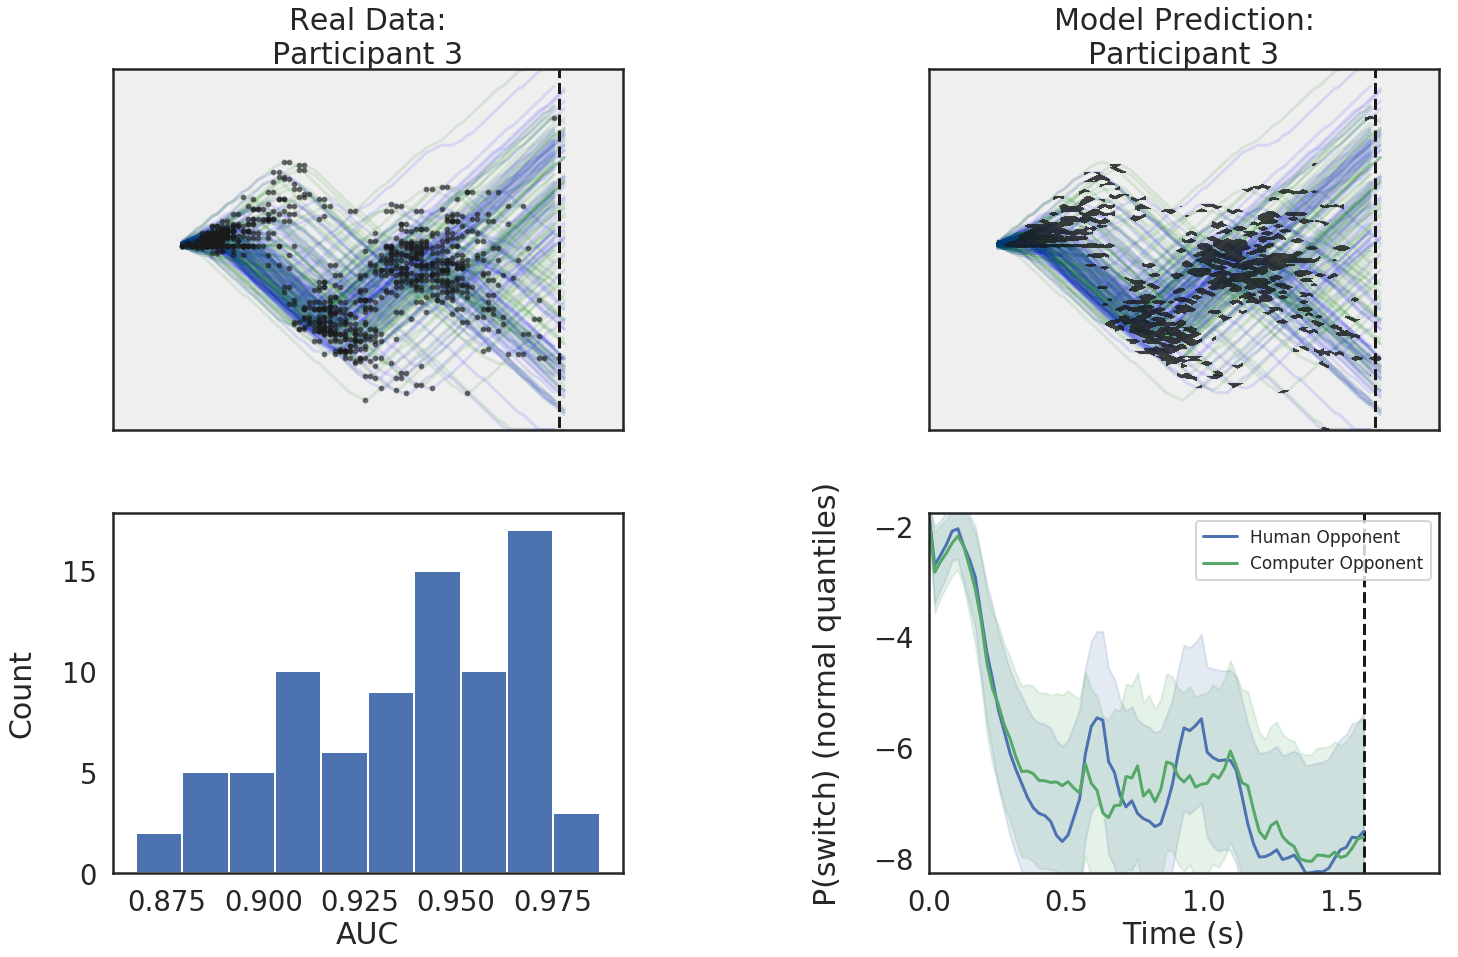

In [15]:
sns.set(style="white",context='poster', font_scale=1.25,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(21,14))

humanblue = '#4682B4'

#Plot 1
subID = 3
col1 = '#0172B2'
col2 = '#CC6600'
ax1.set_facecolor(ps_colors[0])
    
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
data = h5py.File('penaltykickdata.h5','r')
trialidx = np.array(data.get('trialidx')).astype('float32')
inputdata['superindex'] = pd.DataFrame(trialidx).iloc[inputdata.index]

for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax1.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
for t in range(len(subtargets)):
    if subtargets.iloc[t][0] == 1:
        ax1.scatter(inputdata.iloc[t].ShooterXPos,inputdata.iloc[t].ShooterYPos, 
                                                            alpha=0.5, color='k',zorder=2,s=15) 
ax1.vlines(.75, -1, 1, linestyle='dashed'); 
ax1.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax1.set_xlim(-1,1)
ax1.set_yticks([]);
ax1.set_xticks([]);
ax1.set_title("Real Data:\nParticipant 3");

#Plot 2
ax2.set_facecolor(ps_colors[0])
probs = PKutils.calculateProbSwitch(subID)
probs = np.concatenate(probs).ravel()
inputdata['probSwitch'] = probs.flatten()
inputdata = inputdata.round(2)
    
heatmapvals = inputdata.groupby(['ShooterYPos','ShooterXPos'])['probSwitch'].mean()
heatmapMat = heatmapvals.unstack(level=1)
heatmapMat = heatmapMat.reindex(index=heatmapMat.index[::-1])
masked_array = np.ma.array(heatmapMat, mask=np.isnan(heatmapMat));
    
ax2.vlines(.75, -1, 1, linestyle='dashed'); 
for t in inputdata['superindex'].unique().astype('int'): #for each trial
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax2.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)   

inputdata['changepoint'] = subtargets
changes = inputdata[inputdata.changepoint==1]
ax2.contourf(sorted(inputdata['ShooterXPos'].unique()), 
             np.flip(sorted(inputdata['ShooterYPos'].unique()),axis=0), 
            heatmapMat, colors='k', levels=[np.mean(subtargets), 1.0], zorder=100, alpha=0.8)
ax2.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax2.set_xlim(-1,1)
ax2.set_yticks([]);
ax2.set_xticks([]);    
ax2.set_title("Model Prediction:\nParticipant 3")

#Plot 3
ax3.hist(aucs);
ax3.set_xlabel("AUC");
ax3.set_ylabel("Count");
ax3.yaxis.set_label_coords(x=-0.15,y=0.5)

#Plot 4
probitp, varsp = calculateprobitp(subID)
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["probitp"] = probitp[0]
inputdata["varp"] = varsp[0]
time = np.array(data.get('time')).astype('int32')
inputdata['timepoint'] = pd.DataFrame(time).iloc[inputdata.index]
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()

tpmeans_human = []
tpmeans_cpu = []
tpvar_human = []
tpvar_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    tpmeans_human.append(np.mean(grouptpdf_human['probitp']))
    tpvar_human.append(np.mean(grouptpdf_human['varp']))

    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    tpmeans_cpu.append(np.mean(grouptpdf_cpu['probitp']))
    tpvar_cpu.append(np.mean(grouptpdf_cpu['varp']))

#turn variances into std
tpvar_human = np.sqrt(tpvar_human)
tpvar_cpu = np.sqrt(tpvar_cpu)

ax4.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax4.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_human)-np.array(tpvar_human), 
                 np.array(tpmeans_human)+np.array(tpvar_human),color='b',alpha=0.15)

ax4.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax4.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_cpu)-np.array(tpvar_cpu), 
                 np.array(tpmeans_cpu)+np.array(tpvar_cpu),color='g',alpha=0.15)

ax4.set_xlabel("Time (s)")
ax4.set_ylabel('P(switch) (normal quantiles)')
minvlines = np.min([np.min(tpmeans_human), np.min(tpmeans_cpu)])
maxvlines = np.max([np.max(tpmeans_human), np.max(tpmeans_cpu)])
ax4.vlines((nTPs-1)/47.5, minvlines, maxvlines, linestyle='dashed');
ax4.set_ylim((minvlines,maxvlines))
ax4.set_xlim((0,88/47.5))
ax4.legend(prop={'size':17})
ax4.yaxis.set_label_coords(x=-0.17,y=0.5)

fig.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.savefig("presentationplots/fullpswitchmodel.svg",bbox_inches='tight')

In [17]:
grads = []
for subID in np.arange(82):
    grad = PKutils.loadshootersensmetric(subID)
    grads.append(grad)
grads = np.concatenate(grads)

In [21]:
df = PKutils.loaddf()
df["super_index"] = pickledata.super_index
df["time"] = pickledata.time
df["subID"] = pickledata.subID
df["opponent"] = pickledata.opp
df['sens'] = grads
df["logsens"] = np.log(df["sens"])

In [23]:
humanearlysens = []
humanlatesens = []
cpuearlysens = []
cpulatesens = []

for subID in df['subID'].unique():
    subdf = df[df["subID"]==subID]
    earlysubdf = subdf[subdf.time<57]
    latesubdf = subdf[subdf.time>=57]

    humanearly = earlysubdf[earlysubdf["opponent"]==1]
    humanlate = latesubdf[latesubdf["opponent"]==1]
    cpuearly = earlysubdf[earlysubdf["opponent"]==0]
    cpulate = latesubdf[latesubdf["opponent"]==0]
    
    humanearlysens.append(np.mean(humanearly.logsens))
    humanlatesens.append(np.mean(humanlate.logsens))
    cpuearlysens.append(np.mean(cpuearly.logsens))
    cpulatesens.append(np.mean(cpulate.logsens))

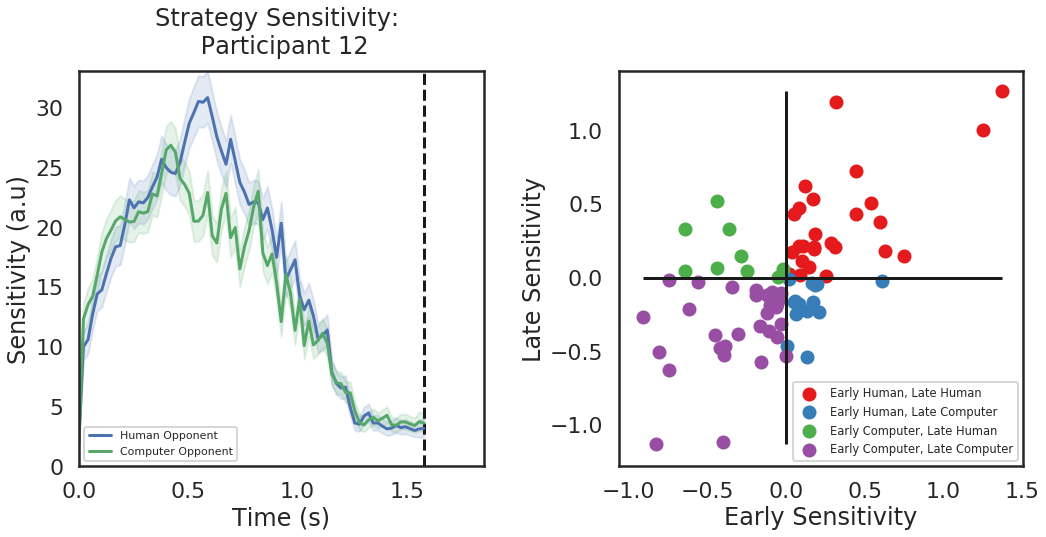

In [24]:
sns.set(style="white",context='poster', font_scale=1.0,font='arial')
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(15,8))


#Plot 1
subID = 12
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["gradmetric"] = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
data = h5py.File('penaltykickdata.h5','r')
time = np.array(data.get('time')).astype('int32')
inputdata['timepoint'] = pd.DataFrame(time).iloc[inputdata.index].values
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()

tpmeans_human = []
tpLCIs_human = []
tpUCIs_human = []
tpmeans_cpu = []
tpLCIs_cpu = []
tpUCIs_cpu = []
for i in inputdata['timepoint'].unique(): 
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    sums_human = np.sum(grouptpdf_human['gradmetric'])
    dfs_human = 2*len(grouptpdf_human)
    tpmeans_human.append(ncx2.mean(dfs_human, sums_human, scale=1/len(grouptpdf_human)))
    LCI, UCI = ncx2.interval(.95, dfs_human, sums_human, loc=0, scale=1/len(grouptpdf_human)) #Endpoints of the range that contains alpha percent of the distribution
    tpLCIs_human.append(LCI)
    tpUCIs_human.append(UCI)
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    sums_cpu = np.sum(grouptpdf_cpu['gradmetric'])
    dfs_cpu = 2*len(grouptpdf_cpu)
    if dfs_cpu == 0:
        tpmeans_cpu.append(2) 
        tpLCIs_cpu.append(2)
        tpUCIs_cpu.append(2)
    else:
        tpmeans_cpu.append(ncx2.mean(dfs_cpu, sums_cpu, scale=1/len(grouptpdf_cpu)))
        LCI, UCI = ncx2.interval(.95, dfs_cpu, sums_cpu, loc=0, scale=1/len(grouptpdf_cpu))
        tpLCIs_cpu.append(LCI)
        tpUCIs_cpu.append(UCI)

ax1.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax1.fill_between(np.arange(nTPs)/47.5, tpLCIs_human, tpUCIs_human,color='b',alpha=0.15)
ax1.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax1.fill_between(np.arange(nTPs)/47.5, tpLCIs_cpu, tpUCIs_cpu,color='g',alpha=0.15)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel('Sensitivity (a.u)')
ax1.set_title("Strategy Sensitivity: \n Participant {}".format(subID),y=1.03)
ax1.vlines((nTPs-1)/47.5, 0, np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)]), linestyle='dashed');
ax1.set_ylim((0,np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)])))
ax1.set_xlim((0,88/47.5))
ax1.legend(loc='lower left',prop={'size':11})

#Plot 2
earlydiff = np.array(humanearlysens) - np.array(cpuearlysens)
latediff= np.array(humanlatesens) - np.array(cpulatesens)

categories = []
for subID in np.arange(82):
    if earlydiff[subID] > 0:
        if latediff[subID] > 0:
            categories.append(1) #human both
        else:
            categories.append(2) #early human, computer late
    else:
        if latediff[subID] > 0:
            categories.append(3) #early computer, late human
        else:
            categories.append(4) #computer both        
            
x = pd.DataFrame(earlydiff, columns=["Early"])
x['Late'] = latediff
x['Color'] = categories

colors = [1,2,3,4]
cmap = matplotlib.cm.get_cmap('Set1')
colorstouse = [cmap(0),cmap(1),cmap(2),cmap(3)]
labels = ["Early Human, Late Human", "Early Human, Late Computer", "Early Computer, Late Human", "Early Computer, Late Computer"]

for i in range(0 , len(colors)):
    data = x.loc[x['Color'] == colors[i]]
    ax2.scatter('Early', 'Late', data=data, c=colorstouse[i], label=labels[i], cmap='Set1')
ax2.legend(loc=4,prop={'size': 11.5})

ax2.vlines(0, np.min(latediff), np.max(latediff),colors='k')
ax2.hlines(0, np.min(earlydiff), np.max(earlydiff),colors='k')

ax2.set_xlabel("Early Sensitivity")
ax2.set_ylabel("Late Sensitivity")

plt.tight_layout()
#plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.savefig("presentationplots/GenuineOppEffectsSens_fullplot.svg",bbox_inches='tight') 

### Across Timescale Variance Analysis

In [25]:
#Calculate mu and lengthscales on a timepoint basis for later averaging
#LONG TIME TO RUN
if os.path.exists("mu_pswitch_everytp.pkl"): #if we've run this cell before, just load in
    if os.path.exists("alllengthscales_pswitch_everytp.pkl"):
        mus = pd.read_pickle("mu_pswitch_everytp.pkl")
        lengthscales = pd.read_pickle("alllengthscales_pswitch_everytp.pkl")
        alllengthscales = np.hstack((lengthscales))
    else:
        allmu = []
        alllengthscales = [] #has nSub*8 entries, one for each lengthscale variable
        for subID in range(82):
            print("Processing Subject {}".format(subID))
            inputdata, subtargets, X_train, X_test, y_train, y_test = loaddata(subID, whichModel='PSwitch')   
            m = loadGPmodel(subID)
            mu, var = m.predict_f(inputdata)
            allmu.append(mu)
            expectation_gradf = []

            inds = np.array([0,1,2,3,4,5,6,7], dtype=np.int32) #index for each variable
            lengthscales = []
            for ind in inds:
                indx = np.array([ind], dtype=np.int32)
                Xph = tf.placeholder(m.X.dtype, shape=(inputdata.shape[0], inputdata.shape[1]))
                data = np.array(inputdata, dtype=m.X.dtype)
                fd = {Xph: data}

                Xdata = tf.data.Dataset.from_tensor_slices(Xph).batch(256)
                iterator = Xdata.make_initializable_iterator()
                next_element = iterator.get_next()

                df, sigma = kelsey_calc_indices(m, next_element, indx)
                dfs = []
                sigmas = []

                with tf.Session() as sess:
                    m.initialize()
                    sess.run(iterator.initializer, feed_dict=fd)
                    while True:
                          try:
                                df1, sigma1 = sess.run([df, sigma], feed_dict=fd)
                                dfs.append(df1)
                                sigmas.append(sigma1)
                          except tf.errors.OutOfRangeError:
                            break
                result = (np.concatenate(dfs).squeeze()**2) / (np.concatenate(sigmas).squeeze()**2) #whiten
                lengthscales.append(np.array(result))
            alllengthscales.append(np.array(lengthscales))

In [26]:
oppSens = []
for subID in range(82):
    oppSens.append(np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID)))
SensMetric = np.concatenate(oppSens)

In [27]:
lsdf = pd.DataFrame(alllengthscales.T)
lsdflog = np.log(lsdf)
lsdflog['mu'] = np.concatenate(mus)
lsdflog["OurOppSensMetric"] = np.log(SensMetric)

In [28]:
lsdflog.columns = ['length_goalieypos','length_shooterxpos','length_shooterypos','length_goalieyvel','length_shooteryvel','length_oppid','length_timesincelastcp','length_oppexper','mu','OurOppSensMetric']

In [29]:
data = h5py.File('penaltykickdata.h5','r')
trialidx = np.array(data.get('trialidx')).astype('float32')
lsdflog['trialindex'] = trialidx

In [30]:
trialgrouped = lsdflog.groupby(['trialindex']).mean()

In [31]:
trialmeans = lsdflog.groupby(['trialindex']).transform("mean")

In [32]:
meancenteredmu = lsdflog["mu"] - trialmeans["mu"]
meancentered_goalieypos = lsdflog["length_goalieypos"] - trialmeans["length_goalieypos"]
meancentered_shooterxpos = lsdflog["length_shooterxpos"] - trialmeans["length_shooterxpos"]
meancentered_shooterypos = lsdflog["length_shooterypos"] - trialmeans["length_shooterypos"]
meancentered_goalieyvel = lsdflog["length_goalieyvel"] - trialmeans["length_goalieyvel"]
meancentered_shooteryvel = lsdflog["length_shooteryvel"] - trialmeans["length_shooteryvel"]
meancentered_oppid = lsdflog["length_oppid"] - trialmeans["length_oppid"]
meancentered_timesincelast = lsdflog["length_timesincelastcp"] - trialmeans["length_timesincelastcp"]
meancentered_oppexper = lsdflog["length_oppexper"] - trialmeans["length_oppexper"]
meancentered_oppsensmetric = lsdflog["OurOppSensMetric"] - trialmeans["OurOppSensMetric"]

In [33]:
meancenteredtp = pd.DataFrame(meancenteredmu, columns=['Mu'])
meancenteredtp["length_goalieypos"] = meancentered_goalieypos
meancenteredtp["length_shooterxpos"] = meancentered_shooterxpos
meancenteredtp["length_shooterypos"] = meancentered_shooterypos
meancenteredtp["length_goalieyvel"] = meancentered_goalieyvel
meancenteredtp["length_shooteryvel"] = meancentered_shooteryvel
meancenteredtp["length_oppid"] = meancentered_oppid
meancenteredtp["length_timesincelast"] = meancentered_timesincelast
meancenteredtp["length_oppexper"] = meancentered_oppexper
meancenteredtp["OurOppSensMetric"] = meancentered_oppsensmetric
meancenteredtp['trialindex'] = lsdflog['trialindex']

In [34]:
meancenteredtp['Mu'] = meancenteredmu

In [35]:
var_trial = meancenteredtp.groupby(['trialindex']).var()

In [36]:
data = h5py.File('penaltykickdata.h5','r')
subID1HE = np.array(data.get('subID')).astype('float32')
subIDs = pd.DataFrame(subID1HE).idxmax(axis=1).values

In [37]:
meancenteredtp.head()

Mu  length_goalieypos  length_shooterxpos  length_shooterypos  \
0  1.218464          -0.457100            3.502392            0.402271   
1  1.452010           0.110080            3.743022            0.967028   
2  1.672475           0.613608            3.956891            1.453566   
3  1.876157           1.065378            4.130329            1.867420   
4  2.060360           1.472252            4.249837            2.206060   

   length_goalieyvel  length_shooteryvel  length_oppid  length_timesincelast  \
0           2.784254            1.326767      1.376426              1.179229   
1           2.896004            1.580109      1.735183              1.569421   
2           2.999583            1.805807      2.088464              1.891148   
3           3.094582            2.000310      2.431554              2.010414   
4           3.180461            2.161020      2.757584              1.636470   

   length_oppexper  OurOppSensMetric  trialindex  
0        -0.148014          0.024387         0.0  
1        -0.071159          0.389425         0.0  
2        -0.008881          0.750190         0.0  
3         0.043189          1.098439         0.0  
4         0.092443          1.428351         0.0

In [42]:
lsdflog['subj'] = df.subID.values
meancenteredtp['subj'] = df.subID.values
subjtrialind = df.groupby(['super_index']).mean()["subID"]

In [43]:
trialgrouped['subj'] = subjtrialind.astype('int')
mu_s = trialgrouped.groupby(['subj']).mean()

In [44]:
v_mu = []
v_goalieypos = []
v_shooterxpos = []
v_shooterypos = []
v_goalieyvel = []
v_shooteryvel = []
v_oppid = []
v_timesincelastcp = []
v_oppexper = []
v_ouroppmetric = []

for trial in range(len(trialgrouped)):
    v_mu.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['mu'] - trialgrouped.iloc[trial]['mu'])
    v_goalieypos.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['length_goalieypos'] - trialgrouped.iloc[trial]['length_goalieypos'])
    v_shooterxpos.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['length_shooterxpos'] - trialgrouped.iloc[trial]['length_shooterxpos'])
    v_shooterypos.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['length_shooterypos'] - trialgrouped.iloc[trial]['length_shooterypos'])
    v_goalieyvel.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['length_goalieyvel'] - trialgrouped.iloc[trial]['length_goalieyvel'])
    v_shooteryvel.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['length_shooteryvel'] - trialgrouped.iloc[trial]['length_shooteryvel'])
    v_oppid.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['length_oppid'] - trialgrouped.iloc[trial]['length_oppid'])
    v_timesincelastcp.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['length_timesincelastcp'] - trialgrouped.iloc[trial]['length_timesincelastcp'])
    v_oppexper.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['length_oppexper'] - trialgrouped.iloc[trial]['length_oppexper'])
    v_ouroppmetric.append(mu_s.loc[trialgrouped.iloc[trial]['subj'].astype('int')]['OurOppSensMetric'] - trialgrouped.iloc[trial]['OurOppSensMetric'])

In [45]:
vdf = pd.DataFrame(v_mu, columns = ['v_mu'])
vdf['v_goalieypos'] = v_goalieypos
vdf['v_shooterxpos'] = v_shooterxpos
vdf['v_shooterypos'] = v_shooterypos
vdf['v_goalieyvel'] = v_goalieyvel
vdf['v_shooteryvel'] = v_shooteryvel
vdf['v_oppid'] = v_oppid
vdf['v_timesincelastcp'] = v_timesincelastcp
vdf['v_oppexper'] = v_oppexper
vdf['v_ouroppmetric'] = v_ouroppmetric
vdf['subj'] = subjtrialind.astype('int')

In [46]:
var_vs = vdf.groupby(['subj']).var()

In [47]:
totalvardf = pd.DataFrame(np.var(meancenteredtp), columns=['tp'])
totalvardf = totalvardf.drop(['subj'])
totalvardf = totalvardf.drop(['trialindex'])

In [48]:
totalvardf['nu_trial'] = np.var(vdf)[0:-1].values
totalvardf['sub'] = np.var(mu_s).values
totalvardf['total'] = np.sum(totalvardf,axis=1)
propvardf = totalvardf.copy()
propvardf['tp'] = propvardf['tp']/propvardf['total']
propvardf['nu_trial'] = propvardf['nu_trial']/propvardf['total']
propvardf['sub'] = propvardf['sub']/propvardf['total']
propvardf['total'] = propvardf['tp'] + propvardf['nu_trial'] + propvardf['sub']
propvardf.to_pickle("correctvardecomposition.pkl")

In [49]:
propvardf

tp  nu_trial       sub  total
Mu                    0.491223  0.087754  0.421023    1.0
length_goalieypos     0.722815  0.145919  0.131266    1.0
length_shooterxpos    0.693196  0.126408  0.180396    1.0
length_shooterypos    0.623277  0.107346  0.269377    1.0
length_goalieyvel     0.711325  0.157070  0.131605    1.0
length_shooteryvel    0.623574  0.124539  0.251887    1.0
length_oppid          0.719486  0.168993  0.111522    1.0
length_timesincelast  0.630659  0.113697  0.255644    1.0
length_oppexper       0.754020  0.185113  0.060868    1.0
OurOppSensMetric      0.613503  0.154256  0.232241    1.0

In [37]:
#Do permutations (start)

In [50]:
origpropvardf = propvardf.copy()

In [51]:
#Construct the full timepoint dataframe in prep for permutations

if os.path.exists("CleanTPDatawithCorrectTrialSubjLabels.csv"):
    meancenteredtp = pd.read_csv("CleanTPDatawithCorrectTrialSubjLabels.csv")
else:
    mus = pd.read_pickle("mu_pswitch_everytp.pkl")
    lengthscales = pd.read_pickle("alllengthscales_pswitch_everytp.pkl")
    alllengthscales = np.hstack((lengthscales))

    oppSens = []
    for subID in range(82):
        oppSens.append(np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID)))
    SensMetric = np.concatenate(oppSens)

    #goalieypos, shooterxpos, shooterypos, goalieyvel, shooteryvel, oppid, timesincelastcp, oppexper
    lsdf = pd.DataFrame(alllengthscales.T)
    lsdflog = np.log(lsdf)
    lsdflog['mu'] = np.concatenate(mus)
    lsdflog["OurOppSensMetric"] = np.log(SensMetric)
    lsdflog.columns = ['length_goalieypos','length_shooterxpos','length_shooterypos','length_goalieyvel','length_shooteryvel','length_oppid','length_timesincelastcp','length_oppexper','mu','OurOppSensMetric']
    data = h5py.File('penaltykickdata.h5','r')
    trialidx = np.array(data.get('trialidx')).astype('float32')
    lsdflog['trialindex'] = trialidx
    trialgrouped = lsdflog.groupby(['trialindex']).mean()
    trialmeans = lsdflog.groupby(['trialindex']).transform("mean")

    meancenteredmu = lsdflog["mu"] - trialmeans["mu"]
    meancentered_goalieypos = lsdflog["length_goalieypos"] - trialmeans["length_goalieypos"]
    meancentered_shooterxpos = lsdflog["length_shooterxpos"] - trialmeans["length_shooterxpos"]
    meancentered_shooterypos = lsdflog["length_shooterypos"] - trialmeans["length_shooterypos"]
    meancentered_goalieyvel = lsdflog["length_goalieyvel"] - trialmeans["length_goalieyvel"]
    meancentered_shooteryvel = lsdflog["length_shooteryvel"] - trialmeans["length_shooteryvel"]
    meancentered_oppid = lsdflog["length_oppid"] - trialmeans["length_oppid"]
    meancentered_timesincelast = lsdflog["length_timesincelastcp"] - trialmeans["length_timesincelastcp"]
    meancentered_oppexper = lsdflog["length_oppexper"] - trialmeans["length_oppexper"]
    meancentered_oppsensmetric = lsdflog["OurOppSensMetric"] - trialmeans["OurOppSensMetric"]
    meancenteredtp = pd.DataFrame(meancenteredmu, columns=['Mu'])
    meancenteredtp["length_goalieypos"] = meancentered_goalieypos
    meancenteredtp["length_shooterxpos"] = meancentered_shooterxpos
    meancenteredtp["length_shooterypos"] = meancentered_shooterypos
    meancenteredtp["length_goalieyvel"] = meancentered_goalieyvel
    meancenteredtp["length_shooteryvel"] = meancentered_shooteryvel
    meancenteredtp["length_oppid"] = meancentered_oppid
    meancenteredtp["length_timesincelast"] = meancentered_timesincelast
    meancenteredtp["length_oppexper"] = meancentered_oppexper
    meancenteredtp["OurOppSensMetric"] = meancentered_oppsensmetric
    meancenteredtp['trialindex'] = lsdflog['trialindex']
    meancenteredtp['Mu'] = meancenteredmu
    data = h5py.File('penaltykickdata.h5','r')
    subID1HE = np.array(data.get('subID')).astype('float32')
    subIDs = pd.DataFrame(subID1HE).idxmax(axis=1).values
    lsdflog['subj'] = subIDs
    meancenteredtp['subj'] = subIDs

In [52]:
#TO BE DONE FOR EVERY PERMUTATION ITERATION. #Note: this cell takes a long time (hours) when run from scratch
if os.path.exists("SubjectPropVar_Permutation.csv"):
    if os.path.exists("TrialPropVar_Permutation.csv"):
        subjPerm = pd.read_csv("SubjectPropVar_Permutation.csv")
        trialPerm = pd.read_csv("TrialPropVar_Permutation.csv")
else:
    numiters = 1000
    nutrialprops = []
    subjprops = []
    np.random.seed(1) 

    for iteration in np.arange(numiters):
        if iteration % 10 == 0:
            print("Iteration: {}".format(iteration))
        meancenteredtp = pd.read_csv("CleanTPDatawithCorrectTrialSubjLabels.csv") #load in clean df
        del meancenteredtp["Unnamed: 0"]

        #permute trial and subject labels while still maintaining within-trial ordering--use dictionary
        origtriallabels = meancenteredtp["trialindex"].unique()
        permtriallabels = np.random.permutation(origtriallabels)
        permdict = dict(zip(origtriallabels,permtriallabels))
        meancenteredtp["trialindex"] = meancenteredtp["trialindex"].replace(permdict)

        origsubjlabels = meancenteredtp["subj"].unique()
        permsubjlabels = np.random.permutation(origsubjlabels)
        permdict = dict(zip(origsubjlabels, permsubjlabels))
        meancenteredtp["subj"] = meancenteredtp["subj"].replace(permdict)

        var_trial = meancenteredtp.groupby(['trialindex']).var()
        trialgrouped = meancenteredtp.groupby(['trialindex']).mean()
        mu_s = trialgrouped.groupby(['subj']).mean()

        v_mu = []
        v_goalieypos = []
        v_shooterxpos = []
        v_shooterypos = []
        v_goalieyvel = []
        v_shooteryvel = []
        v_oppid = []
        v_timesincelastcp = []
        v_oppexper = []
        v_ouroppmetric = []
        for trial in range(len(trialgrouped)):
            v_mu.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['Mu'] - trialgrouped.iloc[trial]['Mu'])
            v_goalieypos.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['length_goalieypos'] - trialgrouped.iloc[trial]['length_goalieypos'])
            v_shooterxpos.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['length_shooterxpos'] - trialgrouped.iloc[trial]['length_shooterxpos'])
            v_shooterypos.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['length_shooterypos'] - trialgrouped.iloc[trial]['length_shooterypos'])
            v_goalieyvel.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['length_goalieyvel'] - trialgrouped.iloc[trial]['length_goalieyvel'])
            v_shooteryvel.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['length_shooteryvel'] - trialgrouped.iloc[trial]['length_shooteryvel'])
            v_oppid.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['length_oppid'] - trialgrouped.iloc[trial]['length_oppid'])
            v_timesincelastcp.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['length_timesincelast'] - trialgrouped.iloc[trial]['length_timesincelast'])
            v_oppexper.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['length_oppexper'] - trialgrouped.iloc[trial]['length_oppexper'])
            v_ouroppmetric.append(mu_s.loc[trialgrouped.iloc[trial]['subj']]['OurOppSensMetric'] - trialgrouped.iloc[trial]['OurOppSensMetric'])

        vdf = pd.DataFrame(v_mu, columns = ['v_mu'])
        vdf['v_goalieypos'] = v_goalieypos
        vdf['v_shooterxpos'] = v_shooterxpos
        vdf['v_shooterypos'] = v_shooterypos
        vdf['v_goalieyvel'] = v_goalieyvel
        vdf['v_shooteryvel'] = v_shooteryvel
        vdf['v_oppid'] = v_oppid
        vdf['v_timesincelastcp'] = v_timesincelastcp
        vdf['v_oppexper'] = v_oppexper
        vdf['v_ouroppmetric'] = v_ouroppmetric
        vdf['subj'] = trialgrouped["subj"]
        var_vs = vdf.groupby(['subj']).var()
        totalvardf = pd.DataFrame(np.var(meancenteredtp), columns=['tp'])
        totalvardf = totalvardf.drop(['subj'])
        totalvardf = totalvardf.drop(['trialindex'])
        totalvardf['nu_trial'] = np.var(vdf)[0:-1].values
        totalvardf['sub'] = np.var(mu_s).values
        totalvardf['total'] = np.sum(totalvardf,axis=1)
        propvardf = totalvardf.copy()
        propvardf['tp'] = propvardf['tp']/propvardf['total']
        propvardf['nu_trial'] = propvardf['nu_trial']/propvardf['total']
        propvardf['sub'] = propvardf['sub']/propvardf['total']
        propvardf['total'] = propvardf['tp'] + propvardf['nu_trial'] + propvardf['sub']

        nutrialprops.append(propvardf["nu_trial"])
        subjprops.append(propvardf["sub"])
    
    
    subj_Mu_perm = []
    subj_goalieypos_perm = []
    subj_shooterxpos_perm  = []
    subj_shooterypos_perm = []
    subj_goalievel_perm = []
    subj_shootervel_perm = []
    subj_oppid_perm = []
    subj_tslc_perm = []
    subj_oppexper_perm = []
    subj_OppSens_perm = []
    for i in np.arange(1000):
        subj_Mu_perm.append(subjprops[i].Mu)
        subj_goalieypos_perm.append(subjprops[i].length_goalieypos)
        subj_shooterxpos_perm.append(subjprops[i].length_shooterxpos)
        subj_shooterypos_perm.append(subjprops[i].length_shooterypos)
        subj_goalievel_perm.append(subjprops[i].length_goalieyvel)
        subj_shootervel_perm.append(subjprops[i].length_shooteryvel)
        subj_oppid_perm.append(subjprops[i].length_oppid)
        subj_tslc_perm.append(subjprops[i].length_timesincelast)
        subj_oppexper_perm.append(subjprops[i].length_oppexper)
        subj_OppSens_perm.append(subjprops[i].OurOppSensMetric)


    trial_Mu_perm = []
    trial_goalieypos_perm = []
    trial_shooterxpos_perm  = []
    trial_shooterypos_perm = []
    trial_goalievel_perm = []
    trial_shootervel_perm = []
    trial_oppid_perm = []
    trial_tslc_perm = []
    trial_oppexper_perm = []
    trial_OppSens_perm = []
    for i in np.arange(1000):
        trial_Mu_perm.append(nutrialprops[i].Mu)
        trial_goalieypos_perm.append(nutrialprops[i].length_goalieypos)
        trial_shooterxpos_perm.append(nutrialprops[i].length_shooterxpos)
        trial_shooterypos_perm.append(nutrialprops[i].length_shooterypos)
        trial_goalievel_perm.append(nutrialprops[i].length_goalieyvel)
        trial_shootervel_perm.append(nutrialprops[i].length_shooteryvel)
        trial_oppid_perm.append(nutrialprops[i].length_oppid)
        trial_tslc_perm.append(nutrialprops[i].length_timesincelast)
        trial_oppexper_perm.append(nutrialprops[i].length_oppexper)
        trial_OppSens_perm.append(nutrialprops[i].OurOppSensMetric)
        
    subjPerm = pd.DataFrame(subj_Mu_perm, columns=["Mu"])
    subjPerm["goalieypos"] = subj_goalieypos_perm
    subjPerm["shooterxpos"] = subj_shooterxpos_perm
    subjPerm["shooterypos"] = subj_shooterypos_perm
    subjPerm["goalievel"] = subj_goalievel_perm 
    subjPerm["shootervel"] = subj_shootervel_perm
    subjPerm["oppid"] = subj_oppid_perm
    subjPerm["tslc"] = subj_tslc_perm
    subjPerm["oppexper"] = subj_oppexper_perm
    subjPerm["OppSens"] = subj_OppSens_perm

    trialPerm = pd.DataFrame(trial_Mu_perm, columns=["Mu"])
    trialPerm["goalieypos"] = trial_goalieypos_perm
    trialPerm["shooterxpos"] = trial_shooterxpos_perm
    trialPerm["shooterypos"] = trial_shooterypos_perm
    trialPerm["goalievel"] = trial_goalievel_perm 
    trialPerm["shootervel"] = trial_shootervel_perm
    trialPerm["oppid"] = trial_oppid_perm
    trialPerm["tslc"] = trial_tslc_perm
    trialPerm["oppexper"] = trial_oppexper_perm
    trialPerm["OppSens"] = trial_OppSens_perm
    
    subjPerm.to_csv("SubjectPropVar_Permutation.csv")
    trialPerm.to_csv("TrialPropVar_Permutation.csv")

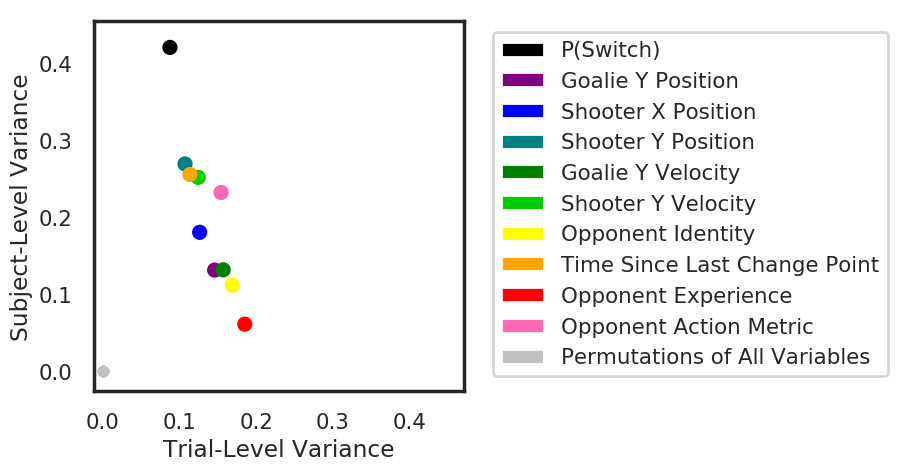

In [54]:
sns.reset_defaults()
sns.set(style="white",context='poster', font_scale=.7,font='arial')
labels = ["P(Switch)","Goalie Y Position","Shooter X Position","Shooter Y Position","Goalie Y Velocity",
         "Shooter Y Velocity","Opponent Identity","Time Since Last Change Point","Opponent Experience","Opponent Action Metric","Permutations of All Variables"]
clist = ['#000000', '#800080','#0000ff','#008080','#008000','#00cd00','#ffff00','#ffa500','#ff0000','#FF69B4','#C0C0C0']
c = range(len(labels))

plt.scatter(origpropvardf.nu_trial, origpropvardf["sub"],s=80,c=clist)
plt.scatter(trialPerm["Mu"], subjPerm["Mu"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["goalieypos"], subjPerm["goalieypos"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["shooterxpos"], subjPerm["shooterxpos"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["shooterypos"], subjPerm["shooterypos"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["goalievel"], subjPerm["goalievel"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["shootervel"], subjPerm["shootervel"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["oppid"], subjPerm["oppid"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["tslc"], subjPerm["tslc"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["oppexper"], subjPerm["oppexper"], s=40,c=clist[10],alpha=0.1)
plt.scatter(trialPerm["OppSens"], subjPerm["OppSens"], s=40,c=clist[10],alpha=0.1)
P.legend([patches.Rectangle((0, 0), 1, 1, 
                       fc=clist[idx])
          for idx in range(len(labels))], 
         labels,bbox_to_anchor=(1.05, 1.00));
plt.ylabel("Subject-Level Variance")
plt.xlabel("Trial-Level Variance");
plt.axis('square');

#plt.savefig("presentationplots/NewVariancePlot.svg",bbox_inches='tight') 

In [55]:
#Extract subject level hyperparameters from GP models. results saved in dataframe as "pswitchhyperparameters.pkl"
#Takes a while to run from scratch

if os.path.exists("pswitchhyperparameters.pkl"): #if we've run this cell before, just load in
    hyperparams = pd.read_pickle("pswitchhyperparameters.pkl")
else:
    lengthscales_goalieypos = []
    lengthscales_shooterxpos = []
    lengthscales_shooterypos = []
    lengthscales_goalieyvel = []
    lengthscales_shooteryvel = []
    lengthscales_opponentid = []
    lengthscales_timesincelastswitch = []
    lengthscales_oppexperience = []
    sigma2 = []

    for s in range(82):
        print("Processing Subject {}".format(s))
        m = loadGPmodel(subID=s)
        lengthscales_goalieypos.append(m.kern.lengthscales.value[0])
        lengthscales_shooterxpos.append(m.kern.lengthscales.value[1])
        lengthscales_shooterypos.append(m.kern.lengthscales.value[2])
        lengthscales_goalieyvel.append(m.kern.lengthscales.value[3])
        lengthscales_shooteryvel.append(m.kern.lengthscales.value[4])
        lengthscales_opponentid.append(m.kern.lengthscales.value[5])
        lengthscales_timesincelastswitch.append(m.kern.lengthscales.value[6])
        lengthscales_oppexperience.append(m.kern.lengthscales.value[7])
        sigma2.append(m.kern.variance.value)
    hyperparams = pd.DataFrame(lengthscales_goalieypos, columns=["goalieypos"])
    hyperparams["shooterxpos"] = lengthscales_shooterxpos
    hyperparams["shooterypos"] = lengthscales_shooterypos
    hyperparams["goalieyvel"] = lengthscales_goalieyvel
    hyperparams["shooteryvel"] = lengthscales_shooteryvel
    hyperparams["opponentid"] = lengthscales_opponentid
    hyperparams["timesincelastswitch"] = lengthscales_timesincelastswitch
    hyperparams["oppexperience"] = lengthscales_oppexperience
    hyperparams["sigma2"] = sigma2    

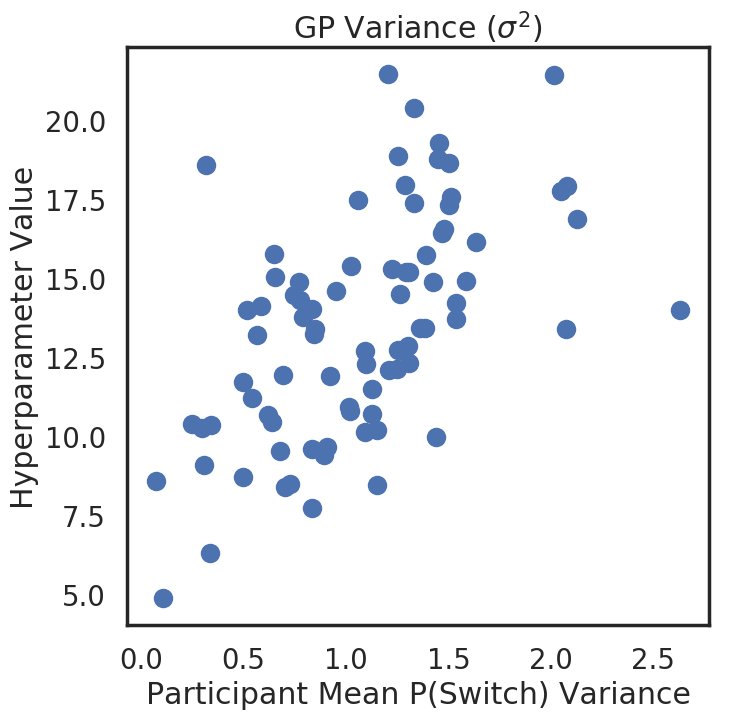

In [56]:
sns.set(style="white",context='poster', font_scale=.9,font='arial')
plt.figure(figsize=(7.5,7.5))
plt.scatter(var_vs["v_mu"], hyperparams["sigma2"])
plt.title("GP Variance ($\sigma^2$)");
plt.xlabel("Participant Mean P(Switch) Variance")
plt.ylabel("Hyperparameter Value");
#plt.savefig("presentationplots/GPVarianceScatter.svg",bbox_inches='tight')

In [57]:
df = 80
r, p = pearsonr(var_vs["v_mu"], hyperparams["sigma2"])
ttest = np.sqrt((df*(r**2))/(1-(r**2))) # straight from nature methods paper, checks out with sklearn's source code
print (r, ttest, p) #how we report pearson r correlations in manuscript

0.5627918514016261 6.089730891307781 3.7281498957975094e-08


In [58]:
r, p = pearsonr(mu_s["length_oppid"], np.log(hyperparams["opponentid"]))
ttest = np.sqrt((df*(r**2))/(1-(r**2))) 
print(r,ttest,p)

-0.6216306337984068 7.0981218113177444 4.5938399901003025e-10


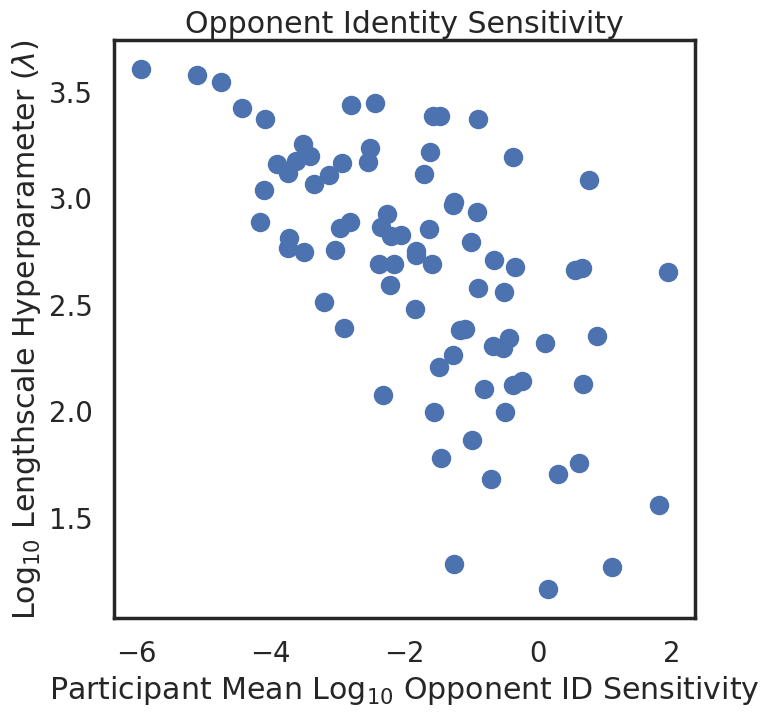

In [59]:
sns.set(style="white",context='poster', font_scale=.9,font='arial')
plt.figure(figsize=(7.5,7.5))
plt.scatter(mu_s["length_oppid"], np.log(hyperparams["opponentid"]))
plt.title("Opponent Identity Sensitivity");
plt.xlabel("Participant Mean $\mathrm{Log}_{10}$ Opponent ID Sensitivity")
plt.ylabel("$\mathrm{Log}_{10}$ Lengthscale Hyperparameter ($\lambda$)");
plt.savefig("presentationplots/oppidlengthscale.svg",bbox_inches='tight')

# Make supplementary figure looking at same analysis but with 3 different numpy random seeds

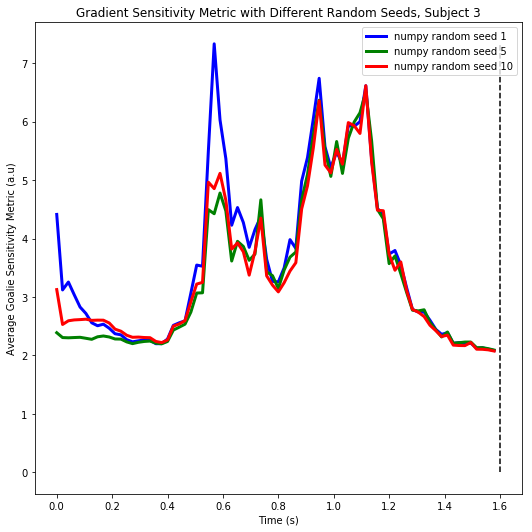

In [17]:
subID = 3
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID, whichModel='PSwitch')
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)

m1 = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
m5 = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=5)
m10 = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=10)

gradmetric1 = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
gradmetric5 = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub3_500IPs_npseed5_200000iters.npy")
gradmetric10 = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub3_500IPs_npseed10_200000iters.npy")

inputdata["gradmetric1"] = gradmetric1
inputdata["gradmetric5"] = gradmetric5
inputdata["gradmetric10"] = gradmetric10

data = h5py.File('penaltykickdata.h5','r')
time = np.array(data.get('time')).astype('int32')
subtimes = pd.DataFrame(time).iloc[inputdata.index]
inputdata['timepoint'] = subtimes
nTPs = inputdata['timepoint'].nunique()

plt.figure(figsize=(7.5,7.5))
ax = plt.gca()

tpmeans_1 = []
tpmeans_5 = []
tpmeans_10 = []

for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf = inputdata[inputdata['timepoint']==i]
    
    sums1 = np.sum(grouptpdf['gradmetric1'])    
    sums5 = np.sum(grouptpdf['gradmetric5'])
    sums10 = np.sum(grouptpdf['gradmetric10'])
    dfs = 2*len(grouptpdf)
    
    tpmeans_1.append(ncx2.mean(dfs, sums1, scale=1/len(grouptpdf)))
    tpmeans_5.append(ncx2.mean(dfs, sums5, scale=1/len(grouptpdf)))
    tpmeans_10.append(ncx2.mean(dfs, sums10, scale=1/len(grouptpdf)))   
    

plt.plot(np.arange(nTPs)/47.5, tpmeans_1,'b',label='numpy random seed 1',linewidth=3)
plt.plot(np.arange(nTPs)/47.5, tpmeans_5,'g',label='numpy random seed 5',linewidth=3)
plt.plot(np.arange(nTPs)/47.5, tpmeans_10,'r',label='numpy random seed 10',linewidth=3)

plt.xlabel("Time (s)")
plt.ylabel('Average Goalie Sensitivity Metric (a.u)')

plt.vlines(nTPs/47.5, 0, np.max([np.max(tpmeans_1), np.max(tpmeans_5), np.max(tpmeans_10)]), linestyle='dashed');
plt.title('Gradient Sensitivity Metric with Different Random Seeds, Subject 3')
plt.legend()
plt.tight_layout()
plt.savefig("presentationplots/npseed_sensitivityplot.pdf",dpi=300, bbox_inches='tight') 

# Compare GP to penalized L1 Logistic Regression

In [62]:
subAUC = []
coeffs = []
subsbestC = []
for subID in np.arange(82):
    print("Subject: {}".format(subID))
    thisSubScores = []
    X, Y, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
    thissubbestScore = 0
    thissubbestAUC = 0
    candidateCs = np.logspace(start=-3, stop=2, num=20)
    for i, C in enumerate(candidateCs):
        clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01, solver='saga')
        clf_l1_LR.fit(X_train, y_train)
        y_pred_score = clf_l1_LR.predict_proba(X_test)
        thisSubScores.append(-log_loss(y_true=y_test, y_pred=y_pred_score)) #root mean squared error
    
    bestModel = np.argmax(thisSubScores)
    
    #Now run the best model and save
    clf_l1_LR = LogisticRegression(C=candidateCs[bestModel], penalty='l1', tol=0.01, solver='saga')
    clf_l1_LR.fit(X_train, y_train)
    subsbestC.append(candidateCs[bestModel])
    coeffs.append(clf_l1_LR.coef_)
    y_pred_score = clf_l1_LR.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_true=y_test, y_score = y_pred_score[:, 1])
    thissubbestAUC = auc(fpr, tpr)
    subAUC.append(thissubbestAUC)

Subject: 0
Subject: 1
Subject: 2
Subject: 3
Subject: 4
Subject: 5
Subject: 6
Subject: 7
Subject: 8
Subject: 9
Subject: 10
Subject: 11
Subject: 12
Subject: 13
Subject: 14
Subject: 15
Subject: 16
Subject: 17
Subject: 18
Subject: 19
Subject: 20
Subject: 21
Subject: 22
Subject: 23
Subject: 24
Subject: 25
Subject: 26
Subject: 27
Subject: 28
Subject: 29
Subject: 30
Subject: 31
Subject: 32
Subject: 33
Subject: 34
Subject: 35
Subject: 36
Subject: 37
Subject: 38
Subject: 39
Subject: 40
Subject: 41
Subject: 42
Subject: 43
Subject: 44
Subject: 45
Subject: 46
Subject: 47
Subject: 48
Subject: 49
Subject: 50
Subject: 51
Subject: 52
Subject: 53
Subject: 54
Subject: 55
Subject: 56
Subject: 57
Subject: 58
Subject: 59
Subject: 60
Subject: 61
Subject: 62
Subject: 63
Subject: 64
Subject: 65
Subject: 66
Subject: 67
Subject: 68
Subject: 69
Subject: 70
Subject: 71
Subject: 72
Subject: 73
Subject: 74
Subject: 75
Subject: 76
Subject: 77
Subject: 78
Subject: 79
Subject: 80
Subject: 81


In [63]:
#Calculate AUC for each subject's policy model, takes roughly 5-7 minutes
aucs_GP = []
for subID in np.arange(82):
    print("Processing Subject {}".format(subID))
    X, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
    m = PKutils.loadGPmodel_PSwitch(subID)
    y_pred_score, _ = m.predict_y(X_test)

    fpr, tpr, _ = roc_curve(y_true=y_test, y_score = y_pred_score)
    roc_auc = auc(fpr, tpr)
    aucs_GP.append(roc_auc)

Processing Subject 0
Processing Subject 1
Processing Subject 2
Processing Subject 3
Processing Subject 4
Processing Subject 5
Processing Subject 6
Processing Subject 7
Processing Subject 8
Processing Subject 9
Processing Subject 10
Processing Subject 11
Processing Subject 12
Processing Subject 13
Processing Subject 14
Processing Subject 15
Processing Subject 16
Processing Subject 17
Processing Subject 18
Processing Subject 19
Processing Subject 20
Processing Subject 21
Processing Subject 22
Processing Subject 23
Processing Subject 24
Processing Subject 25
Processing Subject 26
Processing Subject 27
Processing Subject 28
Processing Subject 29
Processing Subject 30
Processing Subject 31
Processing Subject 32
Processing Subject 33
Processing Subject 34
Processing Subject 35
Processing Subject 36
Processing Subject 37
Processing Subject 38
Processing Subject 39
Processing Subject 40
Processing Subject 41
Processing Subject 42
Processing Subject 43
Processing Subject 44
Processing Subject 4

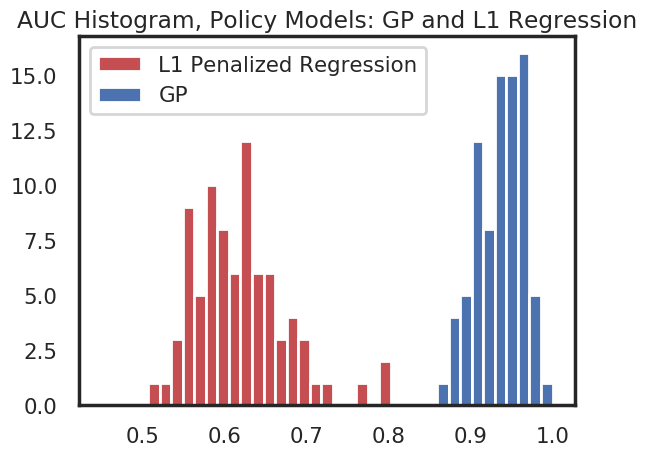

In [65]:
sns.set(style="white",context='poster', font_scale=.7,font='arial')
bins = np.linspace(0.45, 1, 40)
plt.hist(subAUC,bins,color='r',label='L1 Penalized Regression')
plt.hist(aucs_GP,bins,label='GP')
plt.legend()
plt.title("AUC Histogram, Policy Models: GP and L1 Regression");
plt.savefig("presentationplots/AUCHistogramPolicyComparison.svg",bbox_inches='tight')

# Make function for supplement subject plots  for [3,4,12,56]

In [69]:
datafile = PKutils.loaddf()

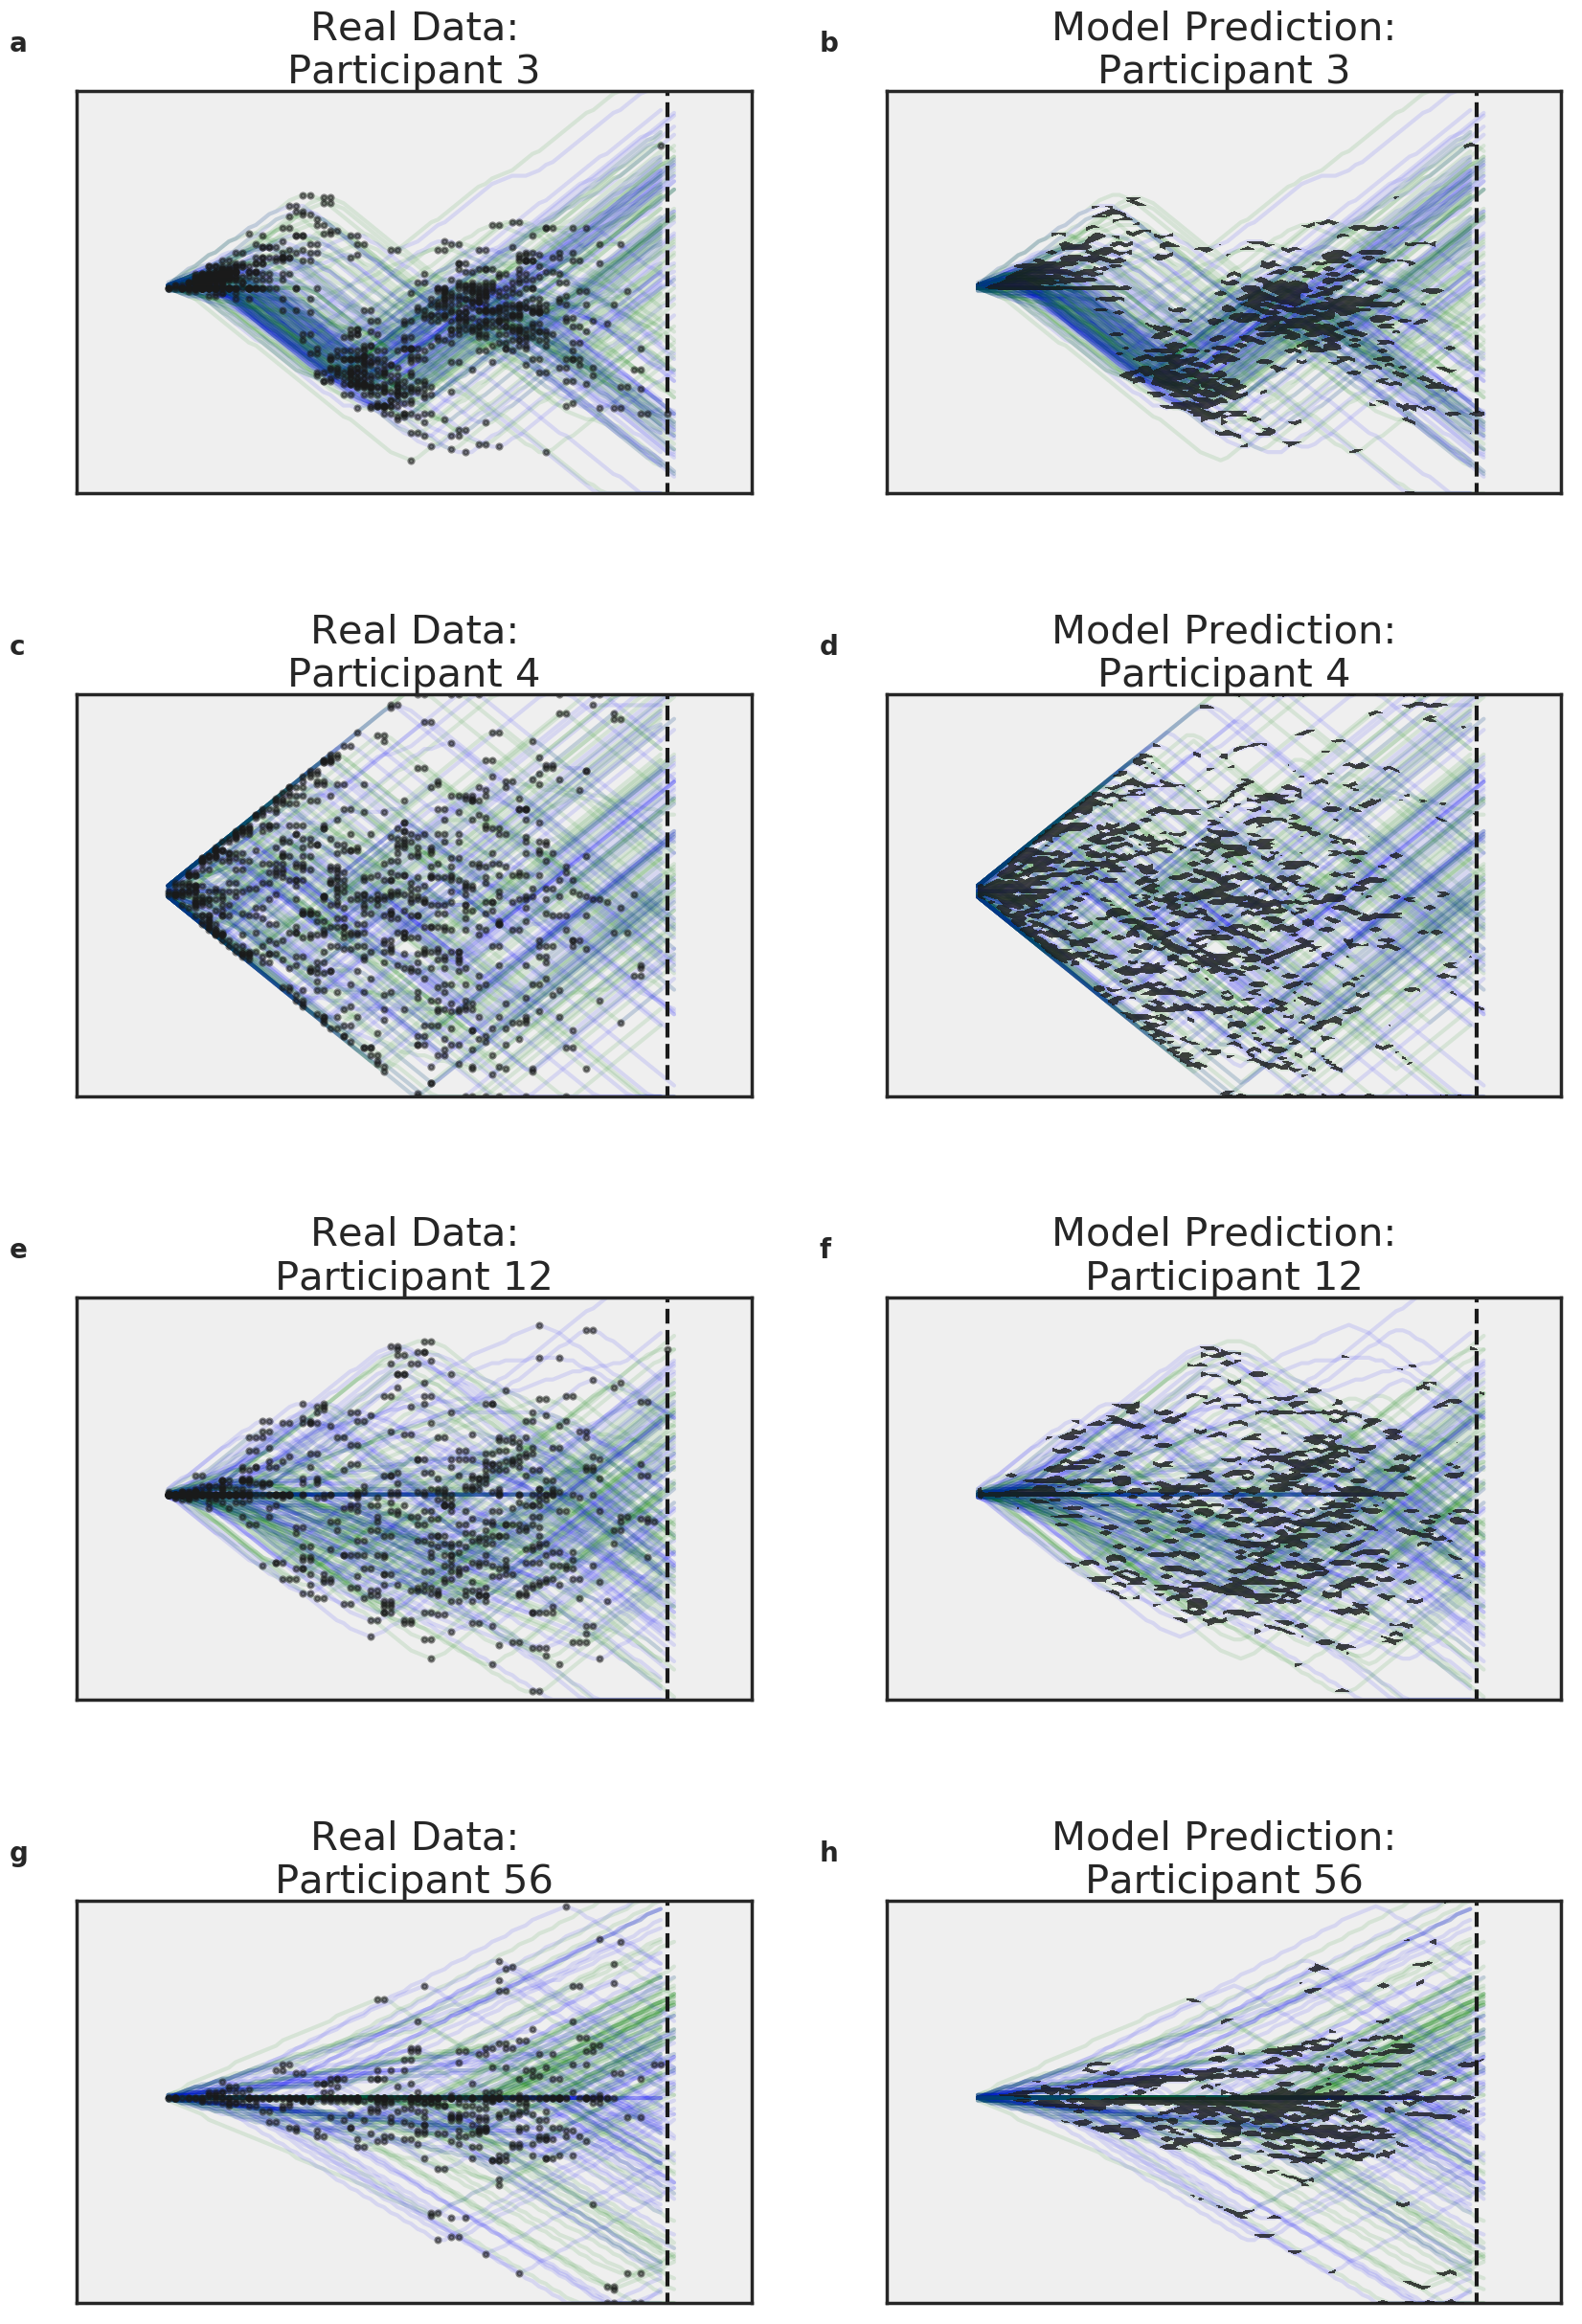

In [71]:
# First, scatter plots
sns.set(style="white",context='poster', font_scale=1.25,font='arial')
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(20,30))

col1 = '#0172B2'
col2 = '#CC6600'

#Plot 1, 1st sub data
subID = 3
ax1.set_facecolor(ps_colors[0])
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
superindex = datafile.iloc[inputdata.index].super_index.values
inputdata['superindex'] = superindex - superindex[0]
for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax1.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
for t in range(len(subtargets)):
    if subtargets.iloc[t][0] == 1:
        ax1.scatter(inputdata.iloc[t].ShooterXPos,inputdata.iloc[t].ShooterYPos, 
                                                            alpha=0.5, color='k',zorder=2,s=15) 
ax1.vlines(.75, -1, 1, linestyle='dashed'); 
ax1.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax1.set_xlim(-1,1)
ax1.set_yticks([]);
ax1.set_xticks([]);
ax1.set_title("Real Data:\nParticipant {}".format(subID));
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=20, weight='bold')

#Plot 2, 1st sub prediction
ax2.set_facecolor(ps_colors[0])
probs = PKutils.calculateProbSwitch(subID)
probs = np.concatenate(probs).ravel()
inputdata['probSwitch'] = probs.flatten()
inputdata = inputdata.round(2)
heatmapvals = inputdata.groupby(['ShooterYPos','ShooterXPos'])['probSwitch'].mean()
heatmapMat = heatmapvals.unstack(level=1)
heatmapMat = heatmapMat.reindex(index=heatmapMat.index[::-1])
masked_array = np.ma.array(heatmapMat, mask=np.isnan(heatmapMat));
ax2.vlines(.75, -1, 1, linestyle='dashed'); 
for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax2.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
inputdata['changepoint'] = subtargets
changes = inputdata[inputdata.changepoint==1]
ax2.contourf(sorted(inputdata['ShooterXPos'].unique()), 
             np.flip(sorted(inputdata['ShooterYPos'].unique()),axis=0), 
            heatmapMat, colors='k', levels=[np.mean(subtargets), 1.0], zorder=100, alpha=0.8)
ax2.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax2.set_xlim(-1,1)
ax2.set_yticks([]);
ax2.set_xticks([]);    
ax2.set_title("Model Prediction:\nParticipant {}".format(subID))
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=20, weight='bold')
              
#Plot 3, 2nd sub data
subID = 4
ax3.set_facecolor(ps_colors[0])
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
superindex = datafile.iloc[inputdata.index].super_index.values
inputdata['superindex'] = superindex - superindex[0]
for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax3.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
for t in range(len(subtargets)):
    if subtargets.iloc[t][0] == 1:
        ax3.scatter(inputdata.iloc[t].ShooterXPos,inputdata.iloc[t].ShooterYPos, 
                                                      alpha=0.5, color='k',zorder=2,s=15) 
ax3.vlines(.75, -1, 1, linestyle='dashed'); 
ax3.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax3.set_xlim(-1,1)
ax3.set_yticks([]);
ax3.set_xticks([]);
ax3.set_title("Real Data:\nParticipant {}".format(subID));
ax3.text(-0.1, 1.1, 'c', transform=ax3.transAxes, size=20, weight='bold')
              
#Plot 4, 2nd sub prediction
ax4.set_facecolor(ps_colors[0])
probs = PKutils.calculateProbSwitch(subID)
probs = np.concatenate(probs).ravel()
inputdata['probSwitch'] = probs.flatten()
inputdata = inputdata.round(2)
heatmapvals = inputdata.groupby(['ShooterYPos','ShooterXPos'])['probSwitch'].mean()
heatmapMat = heatmapvals.unstack(level=1)
heatmapMat = heatmapMat.reindex(index=heatmapMat.index[::-1])
masked_array = np.ma.array(heatmapMat, mask=np.isnan(heatmapMat));
ax4.vlines(.75, -1, 1, linestyle='dashed'); 
for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax4.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
inputdata['changepoint'] = subtargets
changes = inputdata[inputdata.changepoint==1]
ax4.contourf(sorted(inputdata['ShooterXPos'].unique()), 
             np.flip(sorted(inputdata['ShooterYPos'].unique()),axis=0), 
            heatmapMat, colors='k', levels=[np.mean(subtargets), 1.0], zorder=100, alpha=0.8)
ax4.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax4.set_xlim(-1,1)
ax4.set_yticks([]);
ax4.set_xticks([]);    
ax4.set_title("Model Prediction:\nParticipant {}".format(subID))
ax4.text(-0.1, 1.1, 'd', transform=ax4.transAxes, size=20, weight='bold')
    
#Plot 5, 3rd sub data
subID = 12
ax5.set_facecolor(ps_colors[0])
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
superindex = datafile.iloc[inputdata.index].super_index.values
inputdata['superindex'] = superindex - superindex[0]
for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax5.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
for t in range(len(subtargets)):
    if subtargets.iloc[t][0] == 1:
        ax5.scatter(inputdata.iloc[t].ShooterXPos,inputdata.iloc[t].ShooterYPos, 
                                                      alpha=0.5, color='k',zorder=2,s=15) 
ax5.vlines(.75, -1, 1, linestyle='dashed'); 
ax5.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax5.set_xlim(-1,1)
ax5.set_yticks([]);
ax5.set_xticks([]);
ax5.set_title("Real Data:\nParticipant {}".format(subID));
ax5.text(-0.1, 1.1, 'e', transform=ax5.transAxes, size=20, weight='bold')
              
#Plot 6, 3rd sub prediction
ax6.set_facecolor(ps_colors[0])
probs = PKutils.calculateProbSwitch(subID)
probs = np.concatenate(probs).ravel()
inputdata['probSwitch'] = probs.flatten()
inputdata = inputdata.round(2)
heatmapvals = inputdata.groupby(['ShooterYPos','ShooterXPos'])['probSwitch'].mean()
heatmapMat = heatmapvals.unstack(level=1)
heatmapMat = heatmapMat.reindex(index=heatmapMat.index[::-1])
masked_array = np.ma.array(heatmapMat, mask=np.isnan(heatmapMat));
ax6.vlines(.75, -1, 1, linestyle='dashed'); 
for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax6.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
inputdata['changepoint'] = subtargets
changes = inputdata[inputdata.changepoint==1]
ax6.contourf(sorted(inputdata['ShooterXPos'].unique()), 
             np.flip(sorted(inputdata['ShooterYPos'].unique()),axis=0), 
            heatmapMat, colors='k', levels=[np.mean(subtargets), 1.0], zorder=100, alpha=0.8)
ax6.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax6.set_xlim(-1,1)
ax6.set_yticks([]);
ax6.set_xticks([]);    
ax6.set_title("Model Prediction:\nParticipant {}".format(subID))
ax6.text(-0.1, 1.1, 'f', transform=ax6.transAxes, size=20, weight='bold')

#Plot 7, 4th sub data
subID = 56
ax7.set_facecolor(ps_colors[0])
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
superindex = datafile.iloc[inputdata.index].super_index.values
inputdata['superindex'] = superindex - superindex[0]
for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax7.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
for t in range(len(subtargets)):
    if subtargets.iloc[t][0] == 1:
        ax7.scatter(inputdata.iloc[t].ShooterXPos,inputdata.iloc[t].ShooterYPos, 
                                                      alpha=0.5, color='k',zorder=2,s=15) 
ax7.vlines(.75, -1, 1, linestyle='dashed'); 
ax7.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax7.set_xlim(-1,1)
ax7.set_yticks([]);
ax7.set_xticks([]);
ax7.set_title("Real Data:\nParticipant {}".format(subID));
ax7.text(-0.1, 1.1, 'g', transform=ax7.transAxes, size=20, weight='bold')
              
#Plot 8, 4th sub prediction
ax8.set_facecolor(ps_colors[0])
probs = PKutils.calculateProbSwitch(subID)
probs = np.concatenate(probs).ravel()
inputdata['probSwitch'] = probs.flatten()
inputdata = inputdata.round(2)
heatmapvals = inputdata.groupby(['ShooterYPos','ShooterXPos'])['probSwitch'].mean()
heatmapMat = heatmapvals.unstack(level=1)
heatmapMat = heatmapMat.reindex(index=heatmapMat.index[::-1])
masked_array = np.ma.array(heatmapMat, mask=np.isnan(heatmapMat));
ax8.vlines(.75, -1, 1, linestyle='dashed'); 
for t in inputdata['superindex'].unique().astype('int'):
    trialdf = inputdata[inputdata['superindex']==t]
    if trialdf.Opp.iloc[0] == 1:
        colortrial = 'blue'
    elif trialdf.Opp.iloc[0] == 0:
        colortrial = 'green'
    ax8.plot(inputdata[inputdata.superindex==t].ShooterXPos,inputdata[inputdata.superindex==t].ShooterYPos, 
                                                            alpha=0.1, color=colortrial,zorder=1)  
inputdata['changepoint'] = subtargets
changes = inputdata[inputdata.changepoint==1]
ax8.contourf(sorted(inputdata['ShooterXPos'].unique()), 
             np.flip(sorted(inputdata['ShooterYPos'].unique()),axis=0), 
            heatmapMat, colors='k', levels=[np.mean(subtargets), 1.0], zorder=100, alpha=0.8)
ax8.set_ylim((np.min(inputdata['ShooterYPos']),np.max(inputdata['ShooterYPos'])))
ax8.set_xlim(-1,1)
ax8.set_yticks([]);
ax8.set_xticks([]);    
ax8.set_title("Model Prediction:\nParticipant {}".format(subID))
ax8.text(-0.1, 1.1, 'h', transform=ax8.transAxes, size=20, weight='bold')

plt.subplots_adjust(hspace=0.5)
plt.savefig("presentationplots/AllsubsScatter_supplement.pdf",bbox_inches='tight')

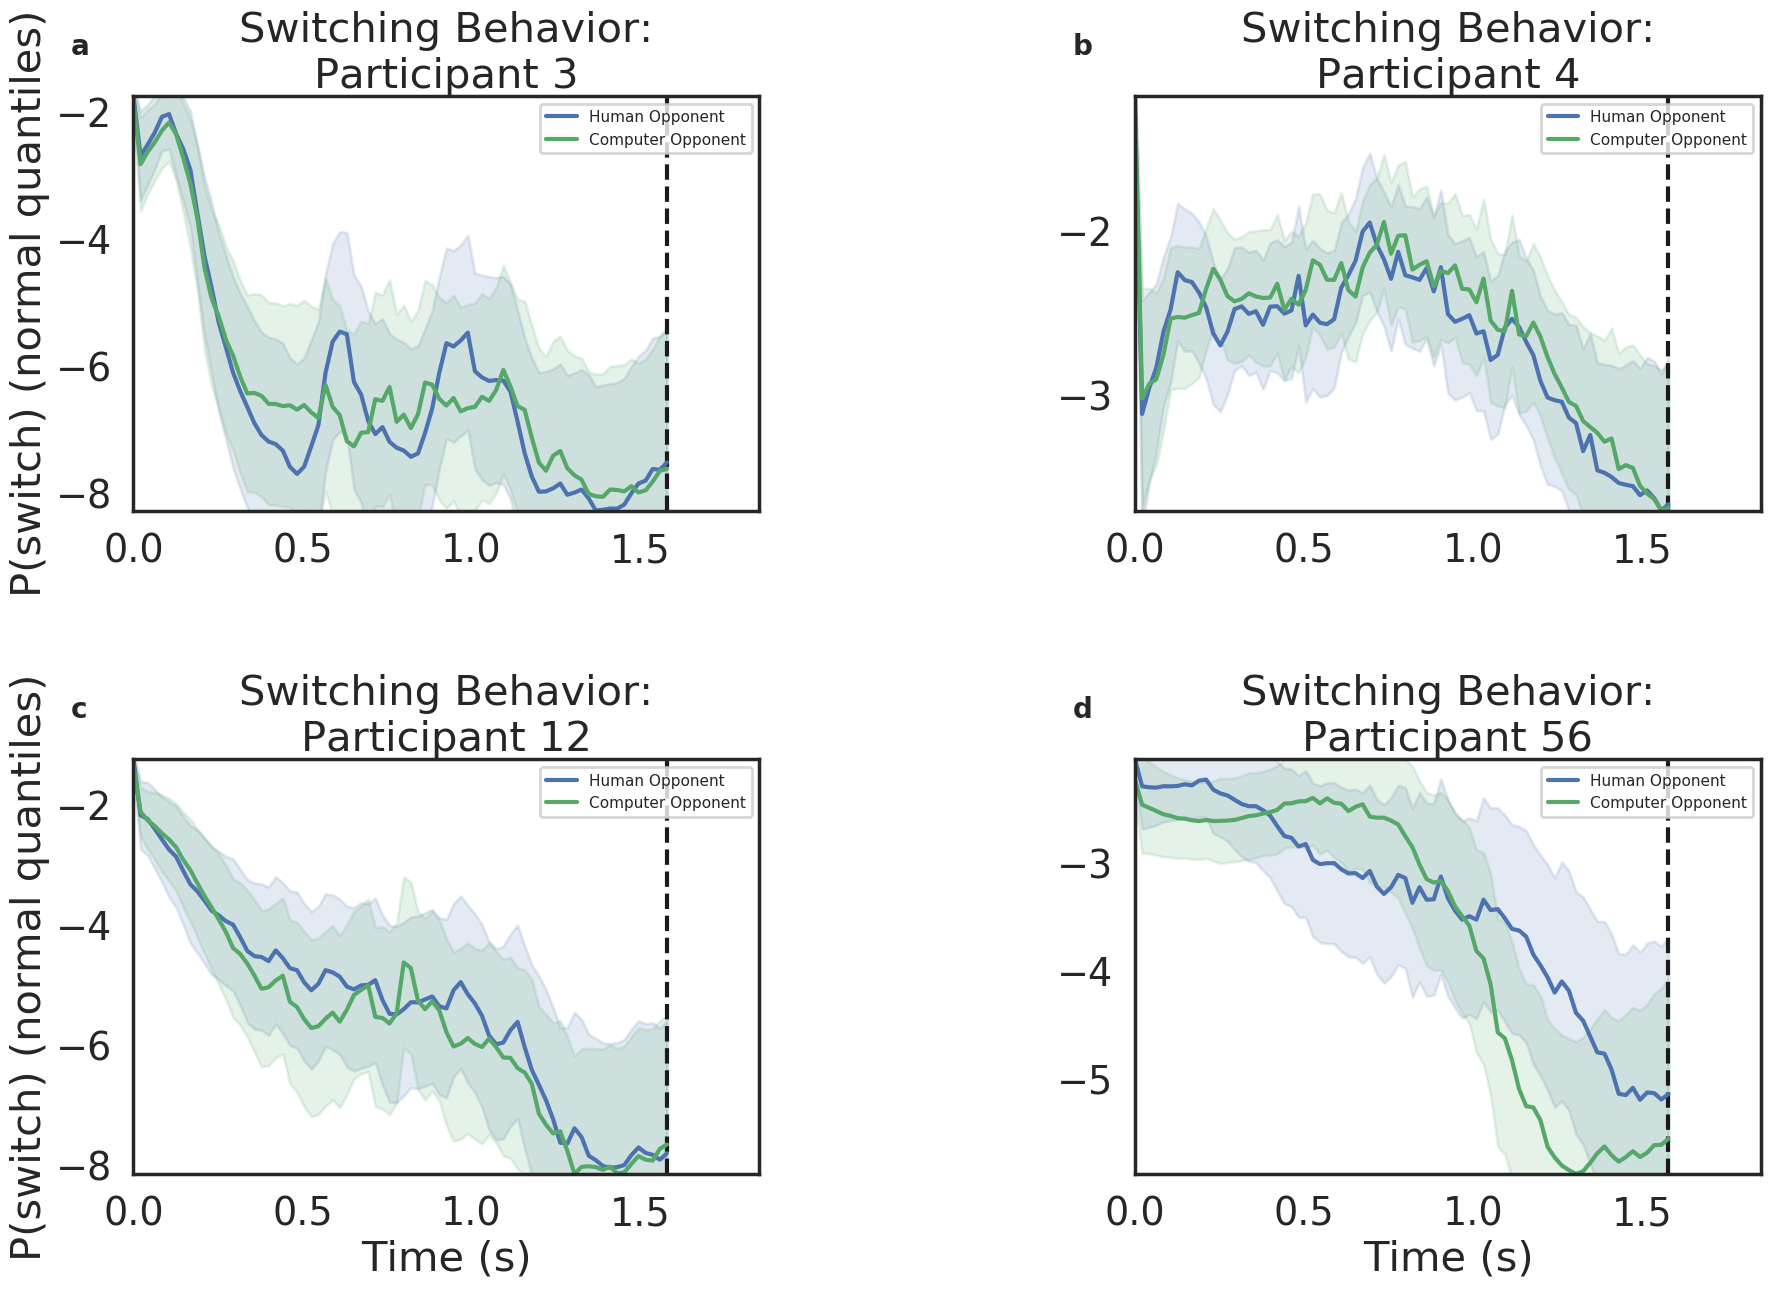

In [72]:
# Probit opponent contrast, normal
sns.set(style="white",context='poster', font_scale=1.25,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(21,14))
data = h5py.File('penaltykickdata.h5','r')
time = np.array(data.get('time')).astype('int32')

#Plot 1
subID = 3
probitp, varsp = calculateprobitp(subID)
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["probitp"] = probitp[0]
inputdata["varp"] = varsp[0]
subtimes = pd.DataFrame(time).iloc[inputdata.index]
inputdata['timepoint'] = subtimes
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()
tpmeans_human = []
tpmeans_cpu = []
tpvar_human = []
tpvar_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    tpmeans_human.append(np.mean(grouptpdf_human['probitp']))
    tpvar_human.append(np.mean(grouptpdf_human['varp']))
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    tpmeans_cpu.append(np.mean(grouptpdf_cpu['probitp']))
    tpvar_cpu.append(np.mean(grouptpdf_cpu['varp']))
tpvar_human = np.sqrt(tpvar_human)
tpvar_cpu = np.sqrt(tpvar_cpu)
ax1.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax1.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_human)-np.array(tpvar_human), 
                 np.array(tpmeans_human)+np.array(tpvar_human),color='b',alpha=0.15)
ax1.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax1.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_cpu)-np.array(tpvar_cpu), 
                 np.array(tpmeans_cpu)+np.array(tpvar_cpu),color='g',alpha=0.15)
ax1.set_ylabel('P(switch) (normal quantiles)')
minvlines = np.min([np.min(tpmeans_human), np.min(tpmeans_cpu)])
maxvlines = np.max([np.max(tpmeans_human), np.max(tpmeans_cpu)])
ax1.vlines((nTPs-1)/47.5, minvlines, maxvlines, linestyle='dashed');
ax1.set_ylim((minvlines,maxvlines))
ax1.set_xlim((0,88/47.5))
ax1.legend(prop={'size':11})
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=20, weight='bold')
ax1.set_title("Switching Behavior:\nParticipant {}".format(subID))

#Plot 2
subID = 4
probitp, varsp = calculateprobitp(subID)
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["probitp"] = probitp[0]
inputdata["varp"] = varsp[0]
subtimes = pd.DataFrame(time).iloc[inputdata.index]
inputdata['timepoint'] = subtimes
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()
tpmeans_human = []
tpmeans_cpu = []
tpvar_human = []
tpvar_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    tpmeans_human.append(np.mean(grouptpdf_human['probitp']))
    tpvar_human.append(np.mean(grouptpdf_human['varp']))
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    tpmeans_cpu.append(np.mean(grouptpdf_cpu['probitp']))
    tpvar_cpu.append(np.mean(grouptpdf_cpu['varp']))
tpvar_human = np.sqrt(tpvar_human)
tpvar_cpu = np.sqrt(tpvar_cpu)
ax2.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax2.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_human)-np.array(tpvar_human), 
                 np.array(tpmeans_human)+np.array(tpvar_human),color='b',alpha=0.15)
ax2.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax2.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_cpu)-np.array(tpvar_cpu), 
                 np.array(tpmeans_cpu)+np.array(tpvar_cpu),color='g',alpha=0.15)
minvlines = np.min([np.min(tpmeans_human), np.min(tpmeans_cpu)])
maxvlines = np.max([np.max(tpmeans_human), np.max(tpmeans_cpu)])
ax2.vlines((nTPs-1)/47.5, minvlines, maxvlines, linestyle='dashed');
ax2.set_ylim((minvlines,maxvlines))
ax2.set_xlim((0,88/47.5))
ax2.legend(prop={'size':11})
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=20, weight='bold')
ax2.set_title("Switching Behavior:\nParticipant {}".format(subID))

#Plot 3
subID = 12
probitp, varsp = calculateprobitp(subID)
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["probitp"] = probitp[0]
inputdata["varp"] = varsp[0]
subtimes = pd.DataFrame(time).iloc[inputdata.index]
inputdata['timepoint'] = subtimes
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()
tpmeans_human = []
tpmeans_cpu = []
tpvar_human = []
tpvar_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    tpmeans_human.append(np.mean(grouptpdf_human['probitp']))
    tpvar_human.append(np.mean(grouptpdf_human['varp']))
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    tpmeans_cpu.append(np.mean(grouptpdf_cpu['probitp']))
    tpvar_cpu.append(np.mean(grouptpdf_cpu['varp']))
tpvar_human = np.sqrt(tpvar_human)
tpvar_cpu = np.sqrt(tpvar_cpu)
ax3.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax3.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_human)-np.array(tpvar_human), 
                 np.array(tpmeans_human)+np.array(tpvar_human),color='b',alpha=0.15)
ax3.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax3.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_cpu)-np.array(tpvar_cpu), 
                 np.array(tpmeans_cpu)+np.array(tpvar_cpu),color='g',alpha=0.15)
ax3.set_xlabel("Time (s)")
ax3.set_ylabel('P(switch) (normal quantiles)')
minvlines = np.min([np.min(tpmeans_human), np.min(tpmeans_cpu)])
maxvlines = np.max([np.max(tpmeans_human), np.max(tpmeans_cpu)])
ax3.vlines((nTPs-1)/47.5, minvlines, maxvlines, linestyle='dashed');
ax3.set_ylim((minvlines,maxvlines))
ax3.set_xlim((0,88/47.5))
ax3.legend(prop={'size':11})
ax3.text(-0.1, 1.1, 'c', transform=ax3.transAxes, size=20, weight='bold')
ax3.set_title("Switching Behavior:\nParticipant {}".format(subID))

#Plot 4
subID = 56
probitp, varsp = calculateprobitp(subID)
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["probitp"] = probitp[0]
inputdata["varp"] = varsp[0]
subtimes = pd.DataFrame(time).iloc[inputdata.index]
inputdata['timepoint'] = subtimes
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()
tpmeans_human = []
tpmeans_cpu = []
tpvar_human = []
tpvar_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    tpmeans_human.append(np.mean(grouptpdf_human['probitp']))
    tpvar_human.append(np.mean(grouptpdf_human['varp']))
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    tpmeans_cpu.append(np.mean(grouptpdf_cpu['probitp']))
    tpvar_cpu.append(np.mean(grouptpdf_cpu['varp']))
tpvar_human = np.sqrt(tpvar_human)
tpvar_cpu = np.sqrt(tpvar_cpu)
ax4.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax4.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_human)-np.array(tpvar_human), 
                 np.array(tpmeans_human)+np.array(tpvar_human),color='b',alpha=0.15)
ax4.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax4.fill_between(np.arange(nTPs)/47.5, np.array(tpmeans_cpu)-np.array(tpvar_cpu), 
                 np.array(tpmeans_cpu)+np.array(tpvar_cpu),color='g',alpha=0.15)
ax4.set_xlabel("Time (s)")
minvlines = np.min([np.min(tpmeans_human), np.min(tpmeans_cpu)])
maxvlines = np.max([np.max(tpmeans_human), np.max(tpmeans_cpu)])
ax4.vlines((nTPs-1)/47.5, minvlines, maxvlines, linestyle='dashed');
ax4.set_ylim((minvlines,maxvlines))
ax4.set_xlim((0,88/47.5))
ax4.legend(prop={'size':11})
ax4.text(-0.1, 1.1, 'd', transform=ax4.transAxes, size=20, weight='bold')
ax4.set_title("Switching Behavior:\nParticipant {}".format(subID))

plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.savefig("presentationplots/allsubsupplement_probitoppnormal.pdf",bbox_inches='tight')

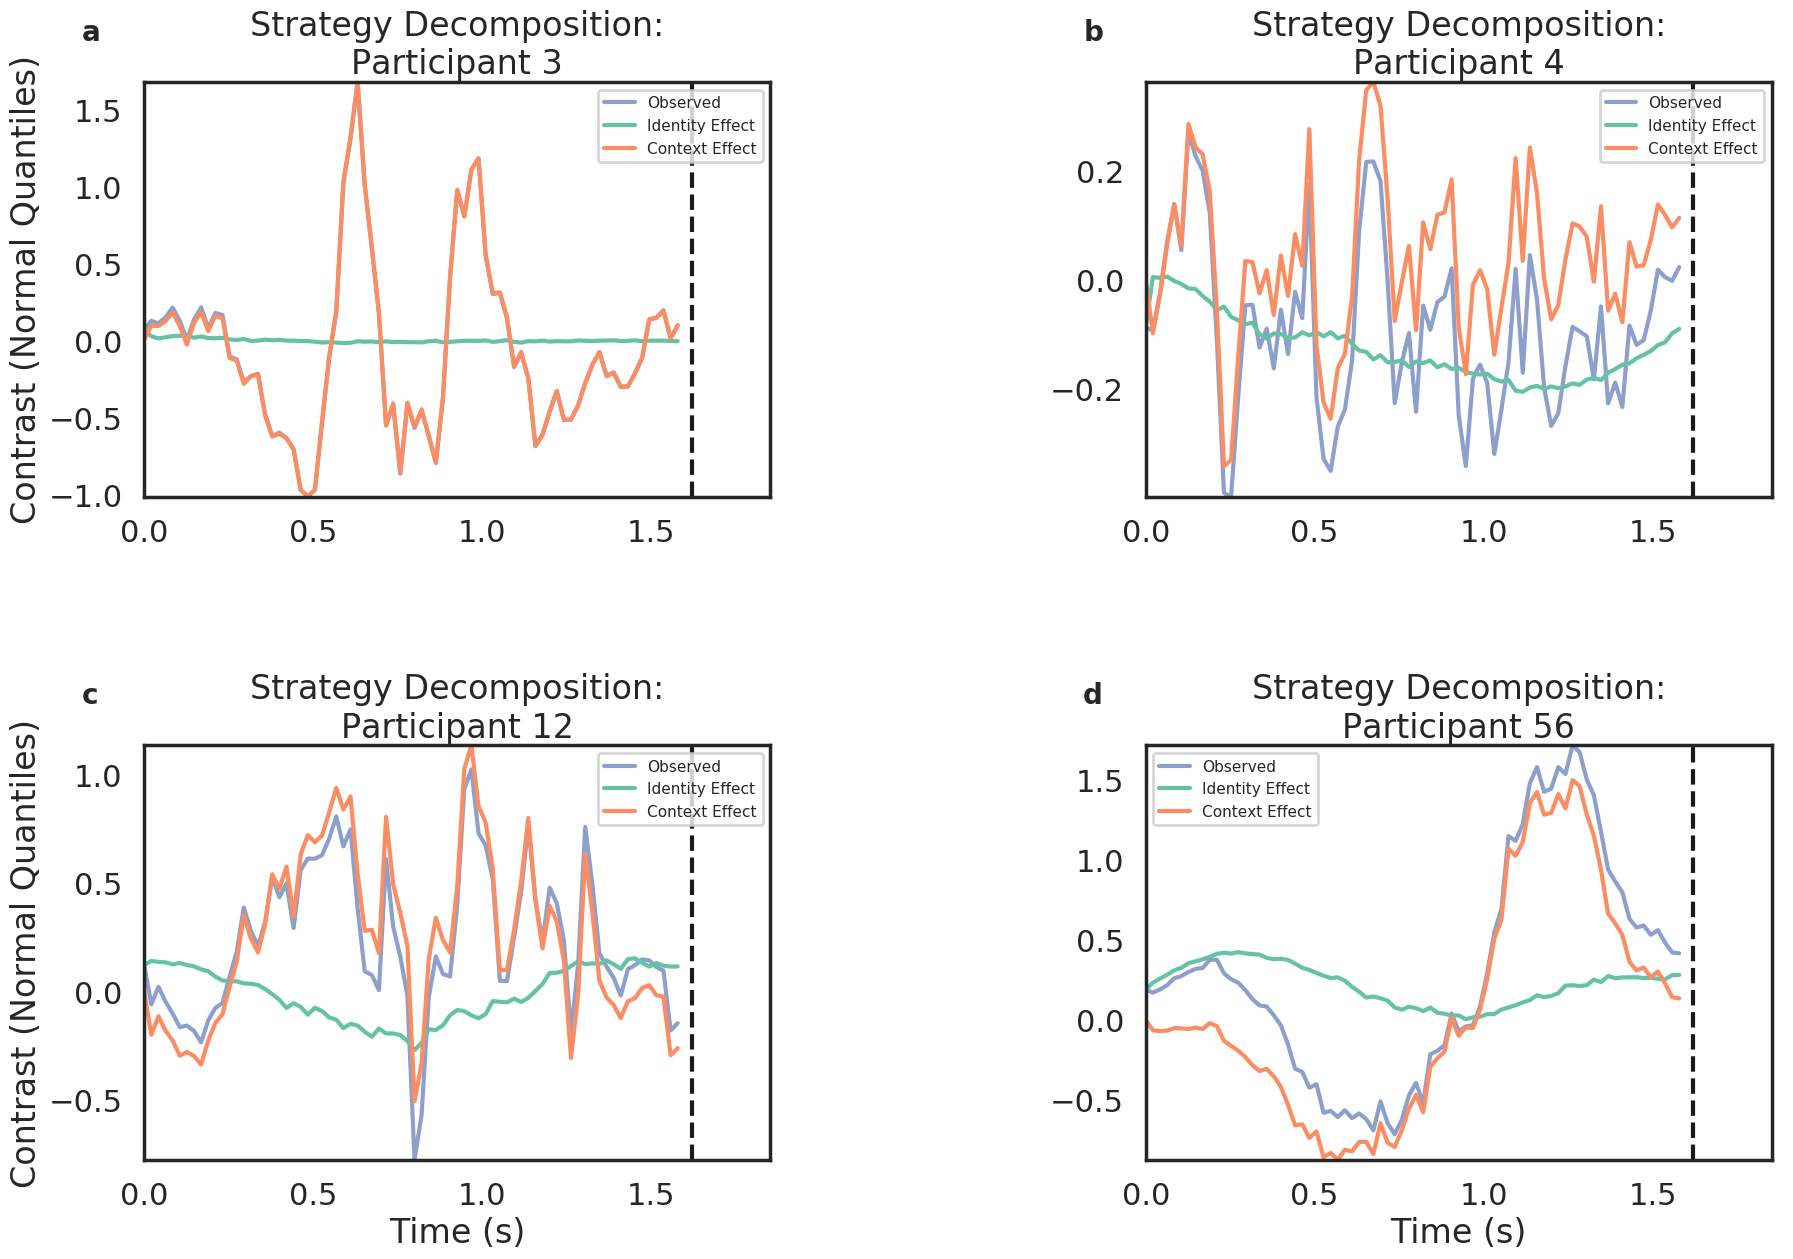

In [83]:
sns.set(style="white",context='poster', font_scale=1.00,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(21,14))

#Plot 1
subID = 3
realprobitp = calculateprobitp(subID)[0] 
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID, whichModel='PSwitch')    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
origdata = inputdata.copy() #origdata is original, inputdata has counterfactual opp values
inputdata['Opp'] = inputdata['Opp'].replace({0: 1, 1:0}) #switch opp for counterfactual
sensinputdata = inputdata.copy() #save a clean copy for the later sensitivity counter analysis
m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
probitp = []
Xfeatures_totaldata = np.array(inputdata, dtype=float)    
dataset = tf.contrib.data.Dataset.from_tensor_slices(Xfeatures_totaldata)
dataset = dataset.batch(len(inputdata))
iterator = dataset.make_one_shot_iterator()
data = iterator.get_next()
m.initialize()   
with tf.Session() as sess:
    mu, var = m.predict_f(data.eval())
    probitp.append(mu)
counterprobitp = probitp[0]
subprobitdata = pd.DataFrame({'realprobitp': realprobitp[0].flatten(), 'counterprobitp':counterprobitp[:,0]})
data = h5py.File('penaltykickdata.h5','r')
subprobitdata['opponent'] = origdata["Opp"].values
#subprobitdata['time'] = np.array(data.get('time')).astype('float32')
times = np.array(data.get('time')).astype('float32')
subprobitdata['time'] = pd.DataFrame(times).iloc[inputdata.index].values
groupeddf = subprobitdata.groupby(['opponent','time']).mean()
countdf = subprobitdata.groupby(['opponent','time']).count()
nCPU = countdf.loc[0]['realprobitp'].values
nHuman = countdf.loc[1]['realprobitp'].values
w0 = nCPU/(nCPU+nHuman)
w1 = nHuman/(nHuman+nCPU)
A = groupeddf.loc[0]['realprobitp'].values
B = groupeddf.loc[1]['counterprobitp'].values
C = groupeddf.loc[0]['counterprobitp'].values
D = groupeddf.loc[1]['realprobitp'].values
OpponentEffect = (w0*(C-A)) + (w1*(D-B))
PolicyEffect = 0.5*((B-A)+(D-C))
RealDataContrast = D-A
nTPs = len(np.unique(time))
ax1.plot(np.arange(nTPs-1)/47.5, RealDataContrast,label='Observed',c='#8da0cb',linewidth=3)
ax1.plot(np.arange(nTPs-1)/47.5, OpponentEffect,c='#66c2a5',label='Identity Effect',linewidth=3)
ax1.plot(np.arange(nTPs-1)/47.5, PolicyEffect,label='Context Effect',c='#fc8d62',linewidth=3)
ax1.set_title("Strategy Decomposition:\nParticipant {}".format(subID))
ax1.set_ylabel('Contrast (Normal Quantiles)')
minvlines = np.min([OpponentEffect,PolicyEffect,RealDataContrast])
maxvlines = np.max([OpponentEffect,PolicyEffect,RealDataContrast])
ax1.vlines(nTPs/47.5, minvlines, maxvlines, linestyle='dashed');
ax1.set_ylim((minvlines,maxvlines))
ax1.set_xlim((0,88/47.5))
ax1.legend(prop={'size':11})
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=20, weight='bold')

#Plot 2
subID = 4
realprobitp = calculateprobitp(subID)[0] 
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID, whichModel='PSwitch')    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
origdata = inputdata.copy() #origdata is original, inputdata has counterfactual opp values
inputdata['Opp'] = inputdata['Opp'].replace({0: 1, 1:0}) #switch opp for counterfactual
sensinputdata = inputdata.copy() #save a clean copy for the later sensitivity counter analysis
m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
probitp = []
Xfeatures_totaldata = np.array(inputdata, dtype=float)    
dataset = tf.contrib.data.Dataset.from_tensor_slices(Xfeatures_totaldata)
dataset = dataset.batch(len(inputdata))
iterator = dataset.make_one_shot_iterator()
data = iterator.get_next()
m.initialize()   
with tf.Session() as sess:
    mu, var = m.predict_f(data.eval())
    probitp.append(mu)
counterprobitp = probitp[0]
subprobitdata = pd.DataFrame({'realprobitp': realprobitp[0].flatten(), 'counterprobitp':counterprobitp[:,0]})
data = h5py.File('penaltykickdata.h5','r')
subprobitdata['opponent'] = origdata["Opp"].values
#subprobitdata['time'] = np.array(data.get('time')).astype('float32')
subprobitdata['time'] = pd.DataFrame(times).iloc[inputdata.index].values
groupeddf = subprobitdata.groupby(['opponent','time']).mean()
countdf = subprobitdata.groupby(['opponent','time']).count()
nCPU = countdf.loc[0]['realprobitp'].values
nHuman = countdf.loc[1]['realprobitp'].values
w0 = nCPU/(nCPU+nHuman)
w1 = nHuman/(nHuman+nCPU)
A = groupeddf.loc[0]['realprobitp'].values
B = groupeddf.loc[1]['counterprobitp'].values
C = groupeddf.loc[0]['counterprobitp'].values
D = groupeddf.loc[1]['realprobitp'].values
OpponentEffect = (w0*(C-A)) + (w1*(D-B))
PolicyEffect = 0.5*((B-A)+(D-C))
RealDataContrast = D-A
nTPs = len(np.unique(time))
ax2.plot(np.arange(nTPs-1)/47.5, RealDataContrast,label='Observed',c='#8da0cb',linewidth=3)
ax2.plot(np.arange(nTPs-1)/47.5, OpponentEffect,c='#66c2a5',label='Identity Effect',linewidth=3)
ax2.plot(np.arange(nTPs-1)/47.5, PolicyEffect,label='Context Effect',c='#fc8d62',linewidth=3)
ax2.set_title("Strategy Decomposition:\nParticipant {}".format(subID))
minvlines = np.min([OpponentEffect,PolicyEffect,RealDataContrast])
maxvlines = np.max([OpponentEffect,PolicyEffect,RealDataContrast])
ax2.vlines(nTPs/47.5, minvlines, maxvlines, linestyle='dashed');
ax2.set_ylim((minvlines,maxvlines))
ax2.set_xlim((0,88/47.5))
ax2.legend(prop={'size':11})
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=20, weight='bold')

#Plot 3
subID = 12
realprobitp = calculateprobitp(subID)[0] 
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID, whichModel='PSwitch')    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
origdata = inputdata.copy() #origdata is original, inputdata has counterfactual opp values
inputdata['Opp'] = inputdata['Opp'].replace({0: 1, 1:0}) #switch opp for counterfactual
sensinputdata = inputdata.copy() #save a clean copy for the later sensitivity counter analysis
m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
probitp = []
Xfeatures_totaldata = np.array(inputdata, dtype=float)    
dataset = tf.contrib.data.Dataset.from_tensor_slices(Xfeatures_totaldata)
dataset = dataset.batch(len(inputdata))
iterator = dataset.make_one_shot_iterator()
data = iterator.get_next()
m.initialize()   
with tf.Session() as sess:
    mu, var = m.predict_f(data.eval())
    probitp.append(mu)
counterprobitp = probitp[0]
subprobitdata = pd.DataFrame({'realprobitp': realprobitp[0].flatten(), 'counterprobitp':counterprobitp[:,0]})
data = h5py.File('penaltykickdata.h5','r')
subprobitdata['opponent'] = origdata["Opp"].values
#subprobitdata['time'] = np.array(data.get('time')).astype('float32')
subprobitdata['time'] = pd.DataFrame(times).iloc[inputdata.index].values
groupeddf = subprobitdata.groupby(['opponent','time']).mean()
countdf = subprobitdata.groupby(['opponent','time']).count()
nCPU = countdf.loc[0]['realprobitp'].values
nHuman = countdf.loc[1]['realprobitp'].values
w0 = nCPU/(nCPU+nHuman)
w1 = nHuman/(nHuman+nCPU)
A = groupeddf.loc[0]['realprobitp'].values
B = groupeddf.loc[1]['counterprobitp'].values
C = groupeddf.loc[0]['counterprobitp'].values
D = groupeddf.loc[1]['realprobitp'].values
OpponentEffect = (w0*(C-A)) + (w1*(D-B))
PolicyEffect = 0.5*((B-A)+(D-C))
RealDataContrast = D-A
nTPs = len(np.unique(time))
ax3.plot(np.arange(nTPs-1)/47.5, RealDataContrast,label='Observed',c='#8da0cb',linewidth=3)
ax3.plot(np.arange(nTPs-1)/47.5, OpponentEffect,c='#66c2a5',label='Identity Effect',linewidth=3)
ax3.plot(np.arange(nTPs-1)/47.5, PolicyEffect,label='Context Effect',c='#fc8d62',linewidth=3)
ax3.set_title("Strategy Decomposition:\nParticipant {}".format(subID))
ax3.set_xlabel("Time (s)")
ax3.set_ylabel('Contrast (Normal Quantiles)')
minvlines = np.min([OpponentEffect,PolicyEffect,RealDataContrast])
maxvlines = np.max([OpponentEffect,PolicyEffect,RealDataContrast])
ax3.vlines(nTPs/47.5, minvlines, maxvlines, linestyle='dashed');
ax3.set_ylim((minvlines,maxvlines))
ax3.set_xlim((0,88/47.5))
ax3.legend(prop={'size':11})
ax3.text(-0.1, 1.1, 'c', transform=ax3.transAxes, size=20, weight='bold')

#Plot 4
subID = 56
realprobitp = calculateprobitp(subID)[0] 
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID, whichModel='PSwitch')    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
origdata = inputdata.copy() #origdata is original, inputdata has counterfactual opp values
inputdata['Opp'] = inputdata['Opp'].replace({0: 1, 1:0}) #switch opp for counterfactual
sensinputdata = inputdata.copy() #save a clean copy for the later sensitivity counter analysis
m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
probitp = []
Xfeatures_totaldata = np.array(inputdata, dtype=float)    
dataset = tf.contrib.data.Dataset.from_tensor_slices(Xfeatures_totaldata)
dataset = dataset.batch(len(inputdata))
iterator = dataset.make_one_shot_iterator()
data = iterator.get_next()
m.initialize()   
with tf.Session() as sess:
    mu, var = m.predict_f(data.eval())
    probitp.append(mu)
counterprobitp = probitp[0]
subprobitdata = pd.DataFrame({'realprobitp': realprobitp[0].flatten(), 'counterprobitp':counterprobitp[:,0]})
data = h5py.File('penaltykickdata.h5','r')
subprobitdata['opponent'] = origdata["Opp"].values
#subprobitdata['time'] = np.array(data.get('time')).astype('float32')
subprobitdata['time'] = pd.DataFrame(times).iloc[inputdata.index].values
groupeddf = subprobitdata.groupby(['opponent','time']).mean()
countdf = subprobitdata.groupby(['opponent','time']).count()
nCPU = countdf.loc[0]['realprobitp'].values
nHuman = countdf.loc[1]['realprobitp'].values
w0 = nCPU/(nCPU+nHuman)
w1 = nHuman/(nHuman+nCPU)
A = groupeddf.loc[0]['realprobitp'].values
B = groupeddf.loc[1]['counterprobitp'].values
C = groupeddf.loc[0]['counterprobitp'].values
D = groupeddf.loc[1]['realprobitp'].values
OpponentEffect = (w0*(C-A)) + (w1*(D-B))
PolicyEffect = 0.5*((B-A)+(D-C))
RealDataContrast = D-A
nTPs = len(np.unique(time))
ax4.plot(np.arange(nTPs-1)/47.5, RealDataContrast,label='Observed',c='#8da0cb',linewidth=3)
ax4.plot(np.arange(nTPs-1)/47.5, OpponentEffect,c='#66c2a5',label='Identity Effect',linewidth=3)
ax4.plot(np.arange(nTPs-1)/47.5, PolicyEffect,label='Context Effect',c='#fc8d62',linewidth=3)
ax4.set_title("Strategy Decomposition:\nParticipant {}".format(subID))
ax4.set_xlabel("Time (s)")
minvlines = np.min([OpponentEffect,PolicyEffect,RealDataContrast])
maxvlines = np.max([OpponentEffect,PolicyEffect,RealDataContrast])
ax4.vlines(nTPs/47.5, minvlines, maxvlines, linestyle='dashed');
ax4.set_ylim((minvlines,maxvlines))
ax4.set_xlim((0,88/47.5))
ax4.legend(prop={'size':11})
ax4.text(-0.1, 1.1, 'd', transform=ax4.transAxes, size=20, weight='bold')

plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.savefig("presentationplots/allsubsupplement_probitpdecompose.pdf",bbox_inches='tight');

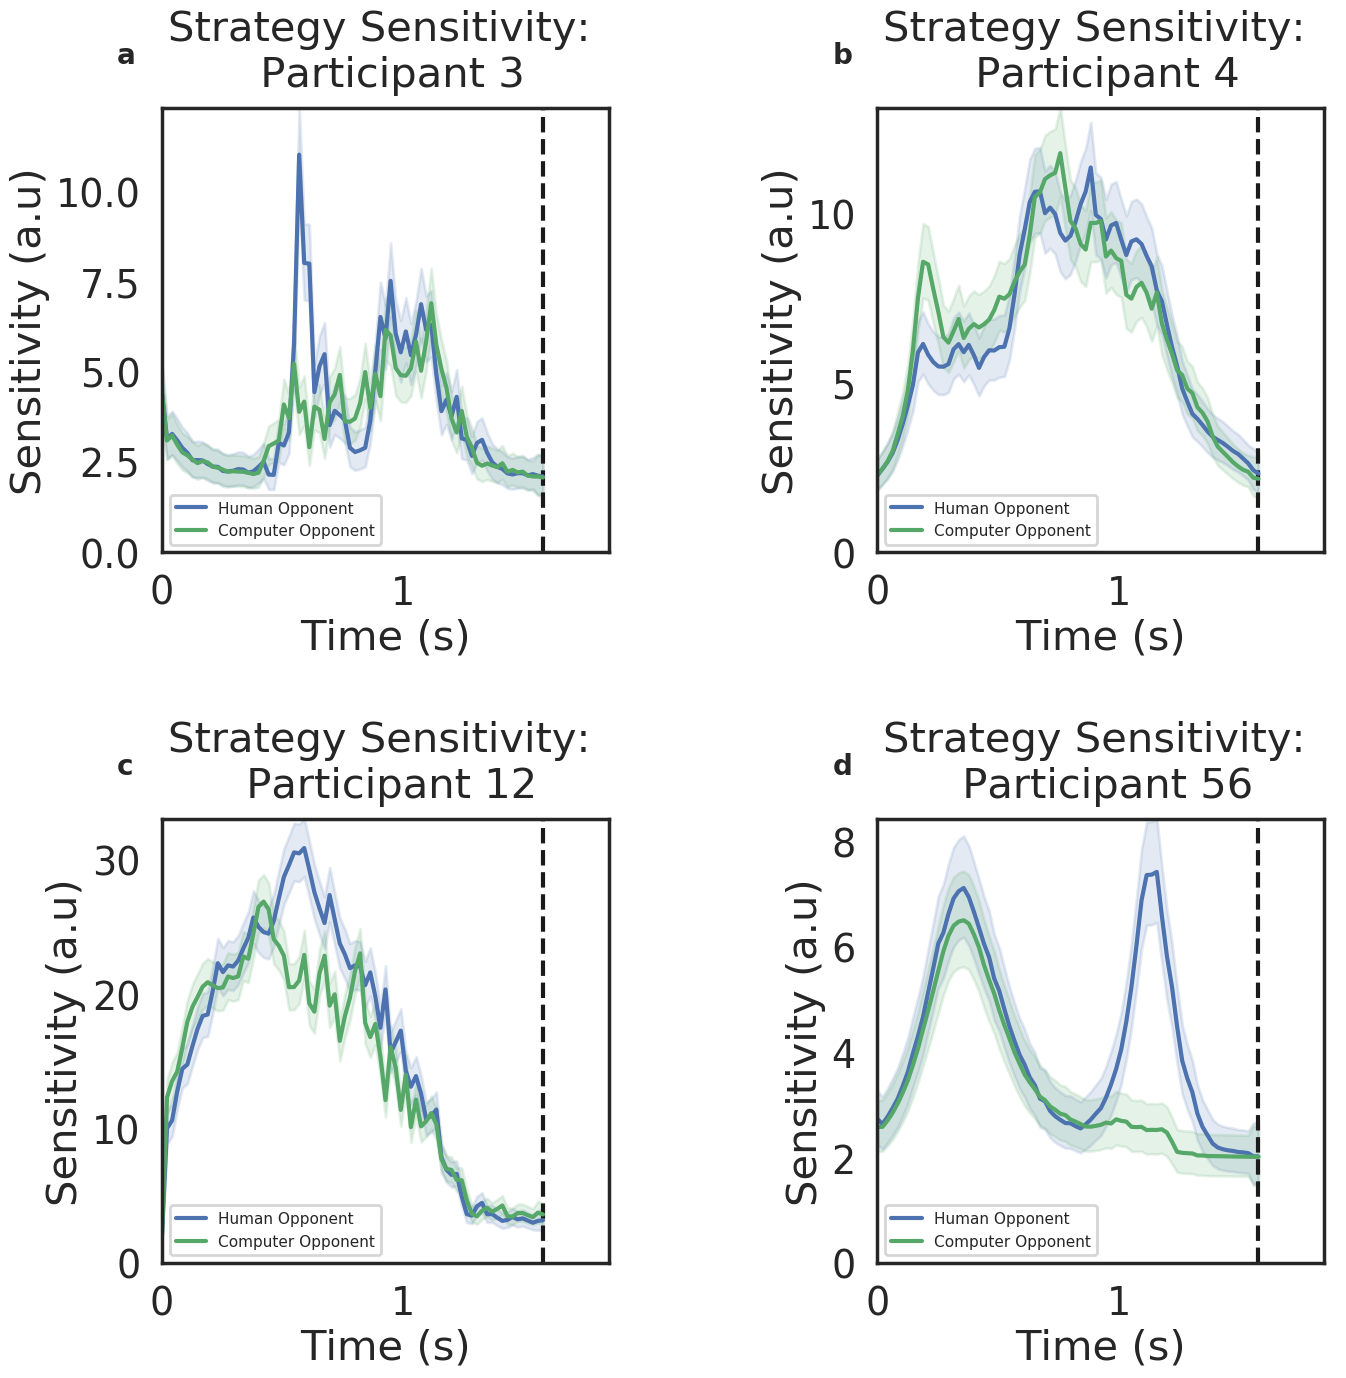

In [84]:
sns.set(style="white",context='poster', font_scale=1.25,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,15))

#Plot 1
subID = 3
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["gradmetric"] = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
inputdata['timepoint'] = pd.DataFrame(time).iloc[inputdata.index]
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()
tpmeans_human = []
tpLCIs_human = []
tpUCIs_human = []
tpmeans_cpu = []
tpLCIs_cpu = []
tpUCIs_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    sums_human = np.sum(grouptpdf_human['gradmetric'])
    dfs_human = 2*len(grouptpdf_human)
    tpmeans_human.append(ncx2.mean(dfs_human, sums_human, scale=1/len(grouptpdf_human)))
    LCI, UCI = ncx2.interval(.95, dfs_human, sums_human, loc=0, scale=1/len(grouptpdf_human)) #Endpoints of the range that contains alpha percent of the distribution
    tpLCIs_human.append(LCI)
    tpUCIs_human.append(UCI)
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    sums_cpu = np.sum(grouptpdf_cpu['gradmetric'])
    dfs_cpu = 2*len(grouptpdf_cpu)
    if dfs_cpu == 0:
        tpmeans_cpu.append(2) #baseline df
        tpLCIs_cpu.append(2)
        tpUCIs_cpu.append(2)
    else:
        tpmeans_cpu.append(ncx2.mean(dfs_cpu, sums_cpu, scale=1/len(grouptpdf_cpu)))
        LCI, UCI = ncx2.interval(.95, dfs_cpu, sums_cpu, loc=0, scale=1/len(grouptpdf_cpu))
        tpLCIs_cpu.append(LCI)
        tpUCIs_cpu.append(UCI)
ax1.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax1.fill_between(np.arange(nTPs)/47.5, tpLCIs_human, tpUCIs_human,color='b',alpha=0.15)
ax1.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax1.fill_between(np.arange(nTPs)/47.5, tpLCIs_cpu, tpUCIs_cpu,color='g',alpha=0.15)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel('Sensitivity (a.u)')
ax1.set_title("Strategy Sensitivity: \n Participant {}".format(subID),y=1.03)
ax1.vlines((nTPs-1)/47.5, 0, np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)]), linestyle='dashed');
ax1.set_ylim((0,np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)])))
ax1.set_xlim((0,88/47.5))
ax1.legend(loc='lower left',prop={'size':11})
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=20, weight='bold')

#Plot 2
subID = 4
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["gradmetric"] = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
inputdata['timepoint'] = pd.DataFrame(time).iloc[inputdata.index]
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()
tpmeans_human = []
tpLCIs_human = []
tpUCIs_human = []
tpmeans_cpu = []
tpLCIs_cpu = []
tpUCIs_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    sums_human = np.sum(grouptpdf_human['gradmetric'])
    dfs_human = 2*len(grouptpdf_human)
    tpmeans_human.append(ncx2.mean(dfs_human, sums_human, scale=1/len(grouptpdf_human)))
    LCI, UCI = ncx2.interval(.95, dfs_human, sums_human, loc=0, scale=1/len(grouptpdf_human)) #Endpoints of the range that contains alpha percent of the distribution
    tpLCIs_human.append(LCI)
    tpUCIs_human.append(UCI)
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    sums_cpu = np.sum(grouptpdf_cpu['gradmetric'])
    dfs_cpu = 2*len(grouptpdf_cpu)
    if dfs_cpu == 0:
        tpmeans_cpu.append(2) #baseline df
        tpLCIs_cpu.append(2)
        tpUCIs_cpu.append(2)
    else:
        tpmeans_cpu.append(ncx2.mean(dfs_cpu, sums_cpu, scale=1/len(grouptpdf_cpu)))
        LCI, UCI = ncx2.interval(.95, dfs_cpu, sums_cpu, loc=0, scale=1/len(grouptpdf_cpu))
        tpLCIs_cpu.append(LCI)
        tpUCIs_cpu.append(UCI)
ax2.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax2.fill_between(np.arange(nTPs)/47.5, tpLCIs_human, tpUCIs_human,color='b',alpha=0.15)
ax2.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax2.fill_between(np.arange(nTPs)/47.5, tpLCIs_cpu, tpUCIs_cpu,color='g',alpha=0.15)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel('Sensitivity (a.u)')
ax2.set_title("Strategy Sensitivity: \n Participant {}".format(subID),y=1.03)
ax2.vlines((nTPs-1)/47.5, 0, np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)]), linestyle='dashed');
ax2.set_ylim((0,np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)])))
ax2.set_xlim((0,88/47.5))
ax2.legend(loc='lower left',prop={'size':11})
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=20, weight='bold')

#Plot 3
subID = 12
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["gradmetric"] = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
inputdata['timepoint'] = pd.DataFrame(time).iloc[inputdata.index]
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()
tpmeans_human = []
tpLCIs_human = []
tpUCIs_human = []
tpmeans_cpu = []
tpLCIs_cpu = []
tpUCIs_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    sums_human = np.sum(grouptpdf_human['gradmetric'])
    dfs_human = 2*len(grouptpdf_human)
    tpmeans_human.append(ncx2.mean(dfs_human, sums_human, scale=1/len(grouptpdf_human)))
    LCI, UCI = ncx2.interval(.95, dfs_human, sums_human, loc=0, scale=1/len(grouptpdf_human)) #Endpoints of the range that contains alpha percent of the distribution
    tpLCIs_human.append(LCI)
    tpUCIs_human.append(UCI)
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    sums_cpu = np.sum(grouptpdf_cpu['gradmetric'])
    dfs_cpu = 2*len(grouptpdf_cpu)
    if dfs_cpu == 0:
        tpmeans_cpu.append(2) #baseline df
        tpLCIs_cpu.append(2)
        tpUCIs_cpu.append(2)
    else:
        tpmeans_cpu.append(ncx2.mean(dfs_cpu, sums_cpu, scale=1/len(grouptpdf_cpu)))
        LCI, UCI = ncx2.interval(.95, dfs_cpu, sums_cpu, loc=0, scale=1/len(grouptpdf_cpu))
        tpLCIs_cpu.append(LCI)
        tpUCIs_cpu.append(UCI)
ax3.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax3.fill_between(np.arange(nTPs)/47.5, tpLCIs_human, tpUCIs_human,color='b',alpha=0.15)
ax3.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax3.fill_between(np.arange(nTPs)/47.5, tpLCIs_cpu, tpUCIs_cpu,color='g',alpha=0.15)
ax3.set_xlabel("Time (s)")
ax3.set_ylabel('Sensitivity (a.u)')
ax3.set_title("Strategy Sensitivity: \n Participant {}".format(subID),y=1.03)
ax3.vlines((nTPs-1)/47.5, 0, np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)]), linestyle='dashed');
ax3.set_ylim((0,np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)])))
ax3.set_xlim((0,88/47.5))
ax3.legend(loc='lower left',prop={'size':11})
ax3.text(-0.1, 1.1, 'c', transform=ax3.transAxes, size=20, weight='bold')

#Plot 4
subID = 56
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
inputdata["gradmetric"] = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
inputdata['timepoint'] = pd.DataFrame(time).iloc[inputdata.index]
subhuman = inputdata[inputdata['Opp']==1]
subcpu = inputdata[inputdata['Opp']==0]
nTPs = inputdata['timepoint'].nunique()
tpmeans_human = []
tpLCIs_human = []
tpUCIs_human = []
tpmeans_cpu = []
tpLCIs_cpu = []
tpUCIs_cpu = []
for i in inputdata['timepoint'].unique(): #20 - 96 timepoints
    grouptpdf_human = subhuman[subhuman['timepoint']==i]
    sums_human = np.sum(grouptpdf_human['gradmetric'])
    dfs_human = 2*len(grouptpdf_human)
    tpmeans_human.append(ncx2.mean(dfs_human, sums_human, scale=1/len(grouptpdf_human)))
    LCI, UCI = ncx2.interval(.95, dfs_human, sums_human, loc=0, scale=1/len(grouptpdf_human)) #Endpoints of the range that contains alpha percent of the distribution
    tpLCIs_human.append(LCI)
    tpUCIs_human.append(UCI)
    grouptpdf_cpu = subcpu[subcpu['timepoint']==i]
    sums_cpu = np.sum(grouptpdf_cpu['gradmetric'])
    dfs_cpu = 2*len(grouptpdf_cpu)
    if dfs_cpu == 0:
        tpmeans_cpu.append(2) #baseline df
        tpLCIs_cpu.append(2)
        tpUCIs_cpu.append(2)
    else:
        tpmeans_cpu.append(ncx2.mean(dfs_cpu, sums_cpu, scale=1/len(grouptpdf_cpu)))
        LCI, UCI = ncx2.interval(.95, dfs_cpu, sums_cpu, loc=0, scale=1/len(grouptpdf_cpu))
        tpLCIs_cpu.append(LCI)
        tpUCIs_cpu.append(UCI)
ax4.plot(np.arange(nTPs)/47.5, tpmeans_human,'b',label='Human Opponent',linewidth=3)
ax4.fill_between(np.arange(nTPs)/47.5, tpLCIs_human, tpUCIs_human,color='b',alpha=0.15)
ax4.plot(np.arange(nTPs)/47.5, tpmeans_cpu,'g',label='Computer Opponent',linewidth=3)
ax4.fill_between(np.arange(nTPs)/47.5, tpLCIs_cpu, tpUCIs_cpu,color='g',alpha=0.15)
ax4.set_xlabel("Time (s)")
ax4.set_ylabel('Sensitivity (a.u)')
ax4.set_title("Strategy Sensitivity: \n Participant {}".format(subID),y=1.03)
ax4.vlines((nTPs-1)/47.5, 0, np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)]), linestyle='dashed');
ax4.set_ylim((0,np.max([np.max(tpUCIs_human), np.max(tpUCIs_cpu)])))
ax4.set_xlim((0,88/47.5))
ax4.legend(loc='lower left',prop={'size':11})
ax4.text(-0.1, 1.1, 'd', transform=ax4.transAxes, size=20, weight='bold')

plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.savefig("presentationplots/allsubsupplement_sens_oppnormal.pdf",bbox_inches='tight');

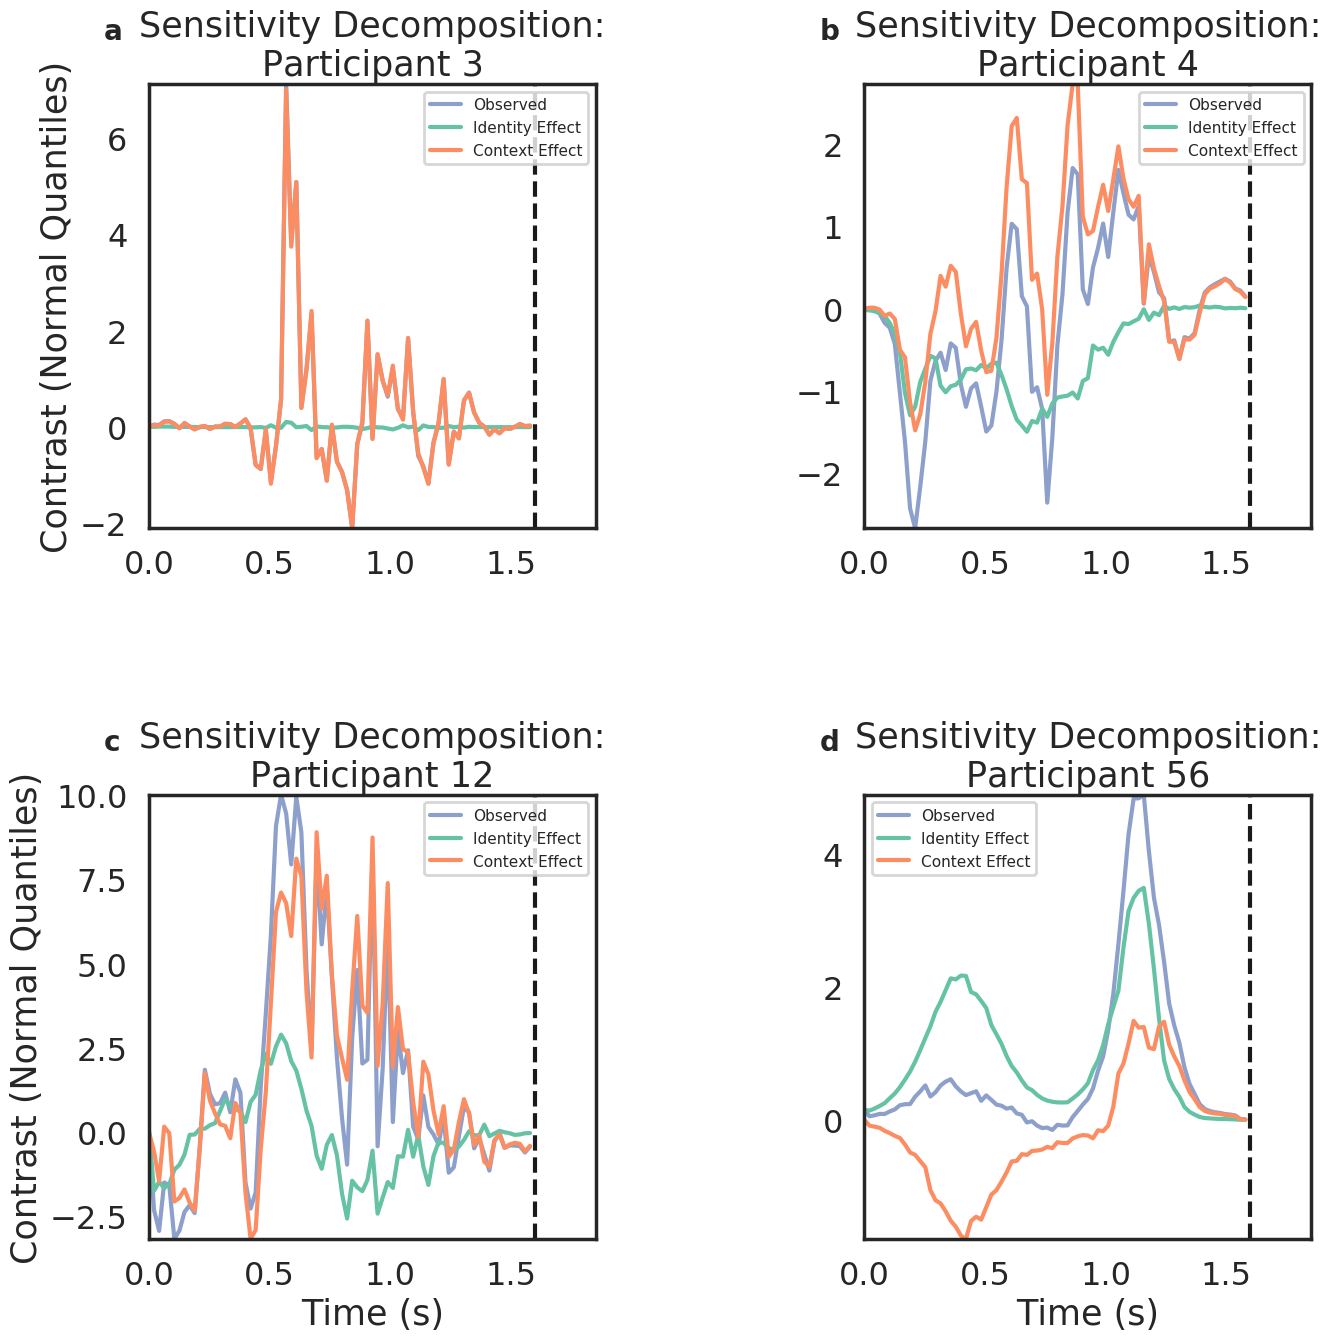

In [87]:
sns.set(style="white",context='poster', font_scale=1.05,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,15))
mb=256
inds = np.array([0, 3], dtype=np.int32)

#Plot 1
subID = 3
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
realsensitivity = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
origdata = inputdata.copy() #origdata is original, inputdata has counterfactual opp values
inputdata['Opp'] = inputdata['Opp'].replace({0: 1, 1:0}) #switch opp for counterfactual
sensinputdata = inputdata.copy() #save a clean copy for the later sensitivity counter analysis
m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
Xph = tf.placeholder(m.X.dtype, shape=(sensinputdata.shape[0], sensinputdata.shape[1]))
data = np.array(sensinputdata, dtype=m.X.dtype)
fd = {Xph: data}
Xdata = tf.data.Dataset.from_tensor_slices(Xph).batch(mb)
iterator = Xdata.make_initializable_iterator()
next_element = iterator.get_next()
df_white = PKutils.kelsey_calc_whitened_indices(m, next_element, inds)
dfs = []
with tf.Session() as sess:
    m.initialize()
    sess.run(iterator.initializer, feed_dict=fd)
    while True:
          try:
            dfs.append(sess.run([df_white], feed_dict=fd)[0])
          except tf.errors.OutOfRangeError:
            break
result = np.concatenate(dfs).squeeze()
countersensitivity = result[:,0]**2 + result[:,1]**2
subprobitdata = pd.DataFrame({'realsens':realsensitivity, 'countersens':countersensitivity})
subprobitdata['opponent'] = origdata["Opp"].values
#subprobitdata['time'] = np.array(data.get('time')).astype('int32')
subprobitdata['time'] = pd.DataFrame(times).iloc[inputdata.index].values
groupeddf = subprobitdata.groupby(['opponent','time']).mean()
countdf = subprobitdata.groupby(['opponent','time']).count()
nCPU = countdf.loc[0]['realsens'].values
nHuman = countdf.loc[1]['realsens'].values
w0 = nCPU/(nCPU+nHuman)
w1 = nHuman/(nHuman+nCPU)
A = groupeddf.loc[0]['realsens'].values
B = groupeddf.loc[1]['countersens'].values
C = groupeddf.loc[0]['countersens'].values
D = groupeddf.loc[1]['realsens'].values
OpponentEffect = (w0*(C-A)) + (w1*(D-B))
PolicyEffect = 0.5*((B-A)+(D-C))
RealDataContrast = D-A
nTPs = len(np.unique(RealDataContrast))
ax1.plot(np.arange(nTPs)/47.5, RealDataContrast,label='Observed',c='#8da0cb',linewidth=3)
ax1.plot(np.arange(nTPs)/47.5, OpponentEffect,c='#66c2a5',label='Identity Effect',linewidth=3)
ax1.plot(np.arange(nTPs)/47.5, PolicyEffect,label='Context Effect',c='#fc8d62',linewidth=3)
ax1.set_title("Sensitivity Decomposition:\nParticipant {}".format(subID))
ax1.set_ylabel('Contrast (Normal Quantiles)')
minvlines = np.min([OpponentEffect,PolicyEffect,RealDataContrast])
maxvlines = np.max([OpponentEffect,PolicyEffect,RealDataContrast])
ax1.vlines(nTPs/47.5, minvlines, maxvlines, linestyle='dashed');
ax1.set_ylim((minvlines,maxvlines))
ax1.set_xlim((0,88/47.5))
ax1.legend(prop={'size':11})
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes, size=20, weight='bold')

#Plot 2
subID = 4
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
realsensitivity = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
origdata = inputdata.copy() #origdata is original, inputdata has counterfactual opp values
inputdata['Opp'] = inputdata['Opp'].replace({0: 1, 1:0}) #switch opp for counterfactual
sensinputdata = inputdata.copy() #save a clean copy for the later sensitivity counter analysis
m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
Xph = tf.placeholder(m.X.dtype, shape=(sensinputdata.shape[0], sensinputdata.shape[1]))
data = np.array(sensinputdata, dtype=m.X.dtype)
fd = {Xph: data}
Xdata = tf.data.Dataset.from_tensor_slices(Xph).batch(mb)
iterator = Xdata.make_initializable_iterator()
next_element = iterator.get_next()
df_white = PKutils.kelsey_calc_whitened_indices(m, next_element, inds)
dfs = []
with tf.Session() as sess:
    m.initialize()
    sess.run(iterator.initializer, feed_dict=fd)
    while True:
          try:
            dfs.append(sess.run([df_white], feed_dict=fd)[0])
          except tf.errors.OutOfRangeError:
            break
result = np.concatenate(dfs).squeeze()
countersensitivity = result[:,0]**2 + result[:,1]**2
subprobitdata = pd.DataFrame({'realsens':realsensitivity, 'countersens':countersensitivity})
subprobitdata['opponent'] = origdata["Opp"].values
#subprobitdata['time'] = np.array(data.get('time')).astype('int32')
subprobitdata['time'] = pd.DataFrame(times).iloc[inputdata.index].values
groupeddf = subprobitdata.groupby(['opponent','time']).mean()
countdf = subprobitdata.groupby(['opponent','time']).count()
nCPU = countdf.loc[0]['realsens'].values
nHuman = countdf.loc[1]['realsens'].values
w0 = nCPU/(nCPU+nHuman)
w1 = nHuman/(nHuman+nCPU)
A = groupeddf.loc[0]['realsens'].values
B = groupeddf.loc[1]['countersens'].values
C = groupeddf.loc[0]['countersens'].values
D = groupeddf.loc[1]['realsens'].values
OpponentEffect = (w0*(C-A)) + (w1*(D-B))
PolicyEffect = 0.5*((B-A)+(D-C))
RealDataContrast = D-A
nTPs = len(np.unique(RealDataContrast))
ax2.plot(np.arange(nTPs)/47.5, RealDataContrast,label='Observed',c='#8da0cb',linewidth=3)
ax2.plot(np.arange(nTPs)/47.5, OpponentEffect,c='#66c2a5',label='Identity Effect',linewidth=3)
ax2.plot(np.arange(nTPs)/47.5, PolicyEffect,label='Context Effect',c='#fc8d62',linewidth=3)
ax2.set_title("Sensitivity Decomposition:\nParticipant {}".format(subID))
minvlines = np.min([OpponentEffect,PolicyEffect,RealDataContrast])
maxvlines = np.max([OpponentEffect,PolicyEffect,RealDataContrast])
ax2.vlines(nTPs/47.5, minvlines, maxvlines, linestyle='dashed');
ax2.set_ylim((minvlines,maxvlines))
ax2.set_xlim((0,88/47.5))
ax2.legend(prop={'size':11})
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes, size=20, weight='bold')

#Plot 3
subID = 12
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
realsensitivity = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
origdata = inputdata.copy() #origdata is original, inputdata has counterfactual opp values
inputdata['Opp'] = inputdata['Opp'].replace({0: 1, 1:0}) #switch opp for counterfactual
sensinputdata = inputdata.copy() #save a clean copy for the later sensitivity counter analysis
m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
Xph = tf.placeholder(m.X.dtype, shape=(sensinputdata.shape[0], sensinputdata.shape[1]))
data = np.array(sensinputdata, dtype=m.X.dtype)
fd = {Xph: data}
Xdata = tf.data.Dataset.from_tensor_slices(Xph).batch(mb)
iterator = Xdata.make_initializable_iterator()
next_element = iterator.get_next()
df_white = PKutils.kelsey_calc_whitened_indices(m, next_element, inds)
dfs = []
with tf.Session() as sess:
    m.initialize()
    sess.run(iterator.initializer, feed_dict=fd)
    while True:
          try:
            dfs.append(sess.run([df_white], feed_dict=fd)[0])
          except tf.errors.OutOfRangeError:
            break
result = np.concatenate(dfs).squeeze()
countersensitivity = result[:,0]**2 + result[:,1]**2
subprobitdata = pd.DataFrame({'realsens':realsensitivity, 'countersens':countersensitivity})
subprobitdata['opponent'] = origdata["Opp"].values
#subprobitdata['time'] = np.array(data.get('time')).astype('int32')
subprobitdata['time'] = pd.DataFrame(times).iloc[inputdata.index].values
groupeddf = subprobitdata.groupby(['opponent','time']).mean()
countdf = subprobitdata.groupby(['opponent','time']).count()
nCPU = countdf.loc[0]['realsens'].values
nHuman = countdf.loc[1]['realsens'].values
w0 = nCPU/(nCPU+nHuman)
w1 = nHuman/(nHuman+nCPU)
A = groupeddf.loc[0]['realsens'].values
B = groupeddf.loc[1]['countersens'].values
C = groupeddf.loc[0]['countersens'].values
D = groupeddf.loc[1]['realsens'].values
OpponentEffect = (w0*(C-A)) + (w1*(D-B))
PolicyEffect = 0.5*((B-A)+(D-C))
RealDataContrast = D-A
nTPs = len(np.unique(RealDataContrast))
ax3.plot(np.arange(nTPs)/47.5, RealDataContrast,label='Observed',c='#8da0cb',linewidth=3)
ax3.plot(np.arange(nTPs)/47.5, OpponentEffect,c='#66c2a5',label='Identity Effect',linewidth=3)
ax3.plot(np.arange(nTPs)/47.5, PolicyEffect,label='Context Effect',c='#fc8d62',linewidth=3)
ax3.set_title("Sensitivity Decomposition:\nParticipant {}".format(subID))
ax3.set_xlabel("Time (s)")
ax3.set_ylabel('Contrast (Normal Quantiles)')
minvlines = np.min([OpponentEffect,PolicyEffect,RealDataContrast])
maxvlines = np.max([OpponentEffect,PolicyEffect,RealDataContrast])
ax3.vlines(nTPs/47.5, minvlines, maxvlines, linestyle='dashed');
ax3.set_ylim((minvlines,maxvlines))
ax3.set_xlim((0,88/47.5))
ax3.legend(prop={'size':11})
ax3.text(-0.1, 1.1, 'c', transform=ax3.transAxes, size=20, weight='bold')

#Plot 4
subID = 56
inputdata, subtargets, X_train, X_test, y_train, y_test = PKutils.loaddata(subID)    
inputdata.rename(columns={0: 'GoalieYPos', 1: 'ShooterXPos', 2: 'ShooterYPos',3: 'GoalieYVel', 4: 'ShooterYVel',5: 'Opp',6:'TimeSinceLastSwitch'}, inplace=True)
inputdata = inputdata.round(2)
realsensitivity = np.load("finalindividsubjGPs/pswitchgradmetric_trimsub{}_500IPs_npseed1_200000iters.npy".format(subID))
origdata = inputdata.copy() #origdata is original, inputdata has counterfactual opp values
inputdata['Opp'] = inputdata['Opp'].replace({0: 1, 1:0}) #switch opp for counterfactual
sensinputdata = inputdata.copy() #save a clean copy for the later sensitivity counter analysis
m = PKutils.loadGPmodel_PSwitch(subID, numIPs=500, iters=200000, mb=256, npseed=1)
Xph = tf.placeholder(m.X.dtype, shape=(sensinputdata.shape[0], sensinputdata.shape[1]))
data = np.array(sensinputdata, dtype=m.X.dtype)
fd = {Xph: data}
Xdata = tf.data.Dataset.from_tensor_slices(Xph).batch(mb)
iterator = Xdata.make_initializable_iterator()
next_element = iterator.get_next()
df_white = PKutils.kelsey_calc_whitened_indices(m, next_element, inds)
dfs = []
with tf.Session() as sess:
    m.initialize()
    sess.run(iterator.initializer, feed_dict=fd)
    while True:
          try:
            dfs.append(sess.run([df_white], feed_dict=fd)[0])
          except tf.errors.OutOfRangeError:
            break
result = np.concatenate(dfs).squeeze()
countersensitivity = result[:,0]**2 + result[:,1]**2
subprobitdata = pd.DataFrame({'realsens':realsensitivity, 'countersens':countersensitivity})
subprobitdata['opponent'] = origdata["Opp"].values 
#subprobitdata['time'] = np.array(data.get('time')).astype('int32')
subprobitdata['time'] = pd.DataFrame(times).iloc[inputdata.index].values
groupeddf = subprobitdata.groupby(['opponent','time']).mean()
countdf = subprobitdata.groupby(['opponent','time']).count()
nCPU = countdf.loc[0]['realsens'].values
nHuman = countdf.loc[1]['realsens'].values
w0 = nCPU/(nCPU+nHuman)
w1 = nHuman/(nHuman+nCPU)
A = groupeddf.loc[0]['realsens'].values
B = groupeddf.loc[1]['countersens'].values
C = groupeddf.loc[0]['countersens'].values
D = groupeddf.loc[1]['realsens'].values
OpponentEffect = (w0*(C-A)) + (w1*(D-B))
PolicyEffect = 0.5*((B-A)+(D-C))
RealDataContrast = D-A
nTPs = len(np.unique(RealDataContrast))
ax4.plot(np.arange(nTPs)/47.5, RealDataContrast,label='Observed',c='#8da0cb',linewidth=3)
ax4.plot(np.arange(nTPs)/47.5, OpponentEffect,c='#66c2a5',label='Identity Effect',linewidth=3)
ax4.plot(np.arange(nTPs)/47.5, PolicyEffect,label='Context Effect',c='#fc8d62',linewidth=3)
ax4.set_title("Sensitivity Decomposition:\nParticipant {}".format(subID))
ax4.set_xlabel("Time (s)")
minvlines = np.min([OpponentEffect,PolicyEffect,RealDataContrast])
maxvlines = np.max([OpponentEffect,PolicyEffect,RealDataContrast])
ax4.vlines(nTPs/47.5, minvlines, maxvlines, linestyle='dashed');
ax4.set_ylim((minvlines,maxvlines))
ax4.set_xlim((0,88/47.5))
ax4.legend(prop={'size':11})
ax4.text(-0.1, 1.1, 'd', transform=ax4.transAxes, size=20, weight='bold')

plt.subplots_adjust(wspace=0.6,hspace=0.6)
plt.savefig("presentationplots/allsubsupplement_sens_decompose.pdf",bbox_inches='tight');

## Make supplement plot of tensorboard hyperparameter tuning

In [88]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

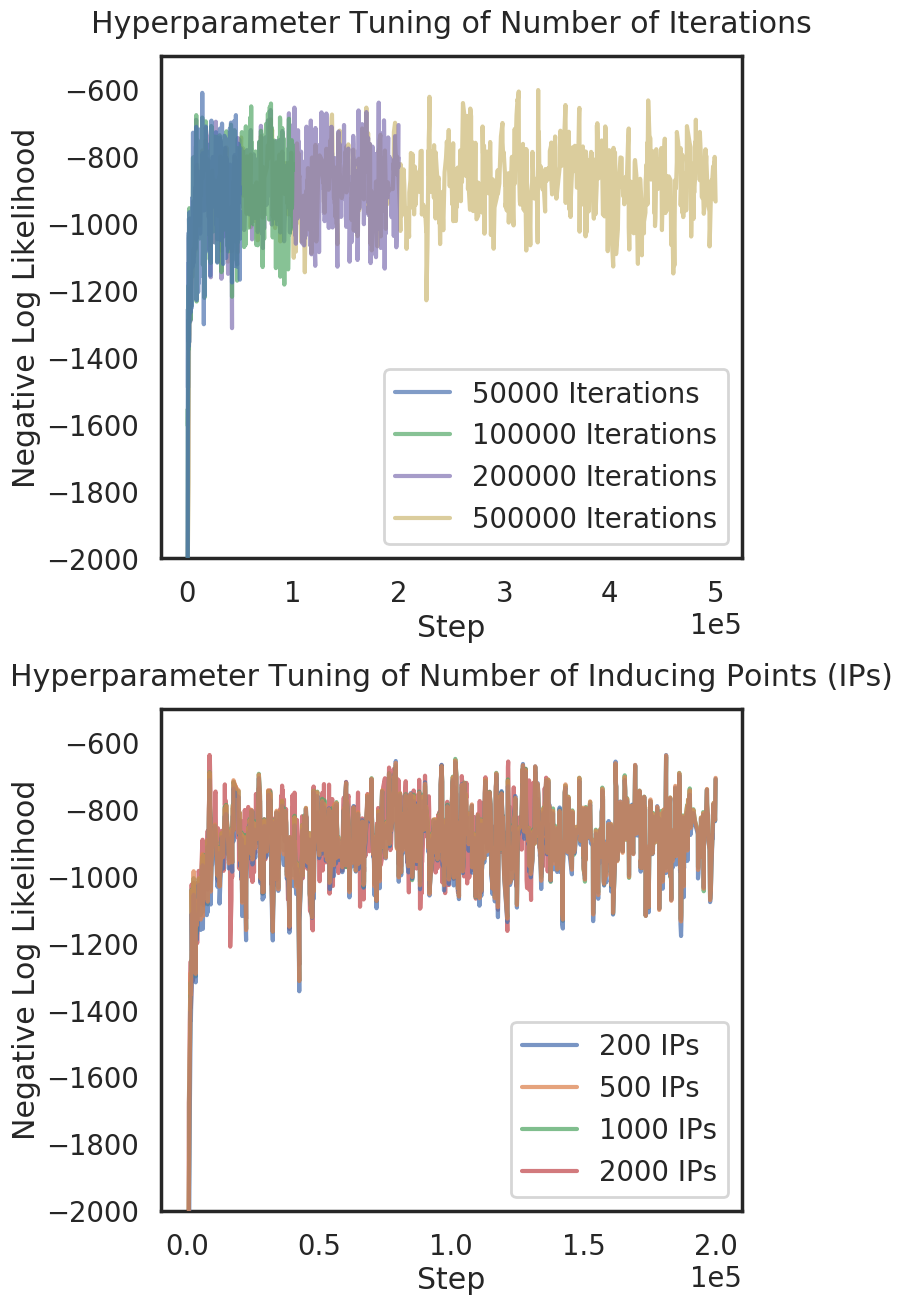

In [89]:
sns.set(style="white",context='poster', font_scale=0.9,font='arial')
fig, ((ax1, ax2)) = plt.subplots(2, 1,figsize=(7.5,15))

# Make plot showing tuning of the number of iterations
x1 = pd.read_csv("finalsubjtrainindivid_logs/hyperparametertuning/run_fulldatatrim_sub3_iters50000_inducingpts500__npseed1-tag-ELBO.csv")
x2 = pd.read_csv("finalsubjtrainindivid_logs/hyperparametertuning/run_fulldatatrim_sub3_iters100000_inducingpts500__npseed1-tag-ELBO.csv")
x3 = pd.read_csv("finalsubjtrainindivid_logs/hyperparametertuning/run_fulldatatrim_sub3_iters200000_inducingpts500__npseed1-tag-ELBO.csv")
x4 = pd.read_csv("finalsubjtrainindivid_logs/hyperparametertuning/run_fulldatatrim_sub3_iters500000_inducingpts500__npseed1-tag-ELBO.csv")

ax1.plot(x1["Step"], smooth(x1["Value"], 0.6),alpha=0.7,label='50000 Iterations',c='b',zorder=4);
ax1.plot(x2["Step"], smooth(x2["Value"], 0.6),alpha=0.7,label='100000 Iterations',c='g',zorder=3);
ax1.plot(x3["Step"], smooth(x3["Value"], 0.6),alpha=0.7,label='200000 Iterations',c='m',zorder=2);
ax1.plot(x4["Step"], smooth(x4["Value"], 0.6),alpha=0.7,label='500000 Iterations',c='y',zorder=1);

ax1.set_ylim((-2000,-500));
ax1.set_xlabel("Step")
ax1.set_ylabel("Negative Log Likelihood")
ax1.set_title("Hyperparameter Tuning of Number of Iterations",y=1.03);
ax1.legend()
ax1.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

# Make plot showing tuning of the number of Inducing Points
x2 = pd.read_csv("finalsubjtrainindivid_logs/hyperparametertuning/run_fulldatatrim_sub3_iters200000_inducingpts200__npseed1-tag-ELBO.csv")
x3 = pd.read_csv("finalsubjtrainindivid_logs/hyperparametertuning/run_fulldatatrim_sub3_iters200000_inducingpts500__npseed1-tag-ELBO.csv")
x4 = pd.read_csv("finalsubjtrainindivid_logs/hyperparametertuning/run_fulldatatrim_sub3_iters200000_inducingpts1000__npseed1-tag-ELBO.csv")
x5 = pd.read_csv("finalsubjtrainindivid_logs/hyperparametertuning/run_fulldatatrim_sub3_iters200000_inducingpts2000__npseed1-tag-ELBO.csv")
                 
#plt.plot(x1["Step"], x1["Value"],alpha=0.7,label='100 IPs',zorder=5);
ax2.plot(x2["Step"], smooth(x2["Value"], 0.6),alpha=0.75,label='200 IPs',zorder=3);
ax2.plot(x3["Step"], smooth(x3["Value"], 0.6),alpha=0.75,label='500 IPs',zorder=4);
ax2.plot(x4["Step"], smooth(x4["Value"], 0.6),alpha=0.75,label='1000 IPs',zorder=2);
ax2.plot(x5["Step"], smooth(x5["Value"], 0.6),alpha=0.75,label='2000 IPs',zorder=1);

ax2.set_ylim((-2000,-500));
ax2.set_xlabel("Step")
ax2.set_ylabel("Negative Log Likelihood")
ax2.set_title("Hyperparameter Tuning of Number of Inducing Points (IPs)",y=1.03);
ax2.legend();
ax2.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

plt.subplots_adjust(hspace=0.3)
plt.savefig("presentationplots/hyperparamtuning.pdf",bbox_inches='tight')

### Plot each subject's length-scale parameter for opponent experience

In [90]:
hyperparams = pd.read_pickle("pswitchhyperparameters.pkl")
oppexperience = hyperparams["oppexperience"]

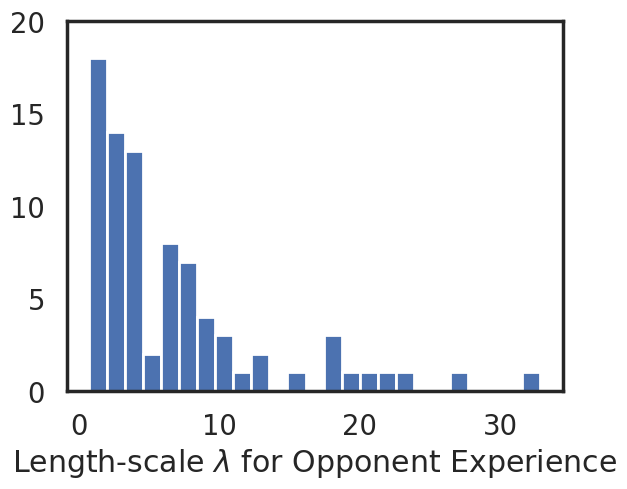

In [91]:
sns.set(style="white",context='poster', font_scale=0.9,font='arial')
plt.hist(oppexperience,bins=25);
plt.ylim((0,20));
plt.xlabel(r"Length-scale $\lambda$ for Opponent Experience")
plt.savefig("presentationplots/oppexperiencelambda_learning.svg",bbox_inches='tight')

# Make figure showing first 10 and last 10 trials for 4 subjects

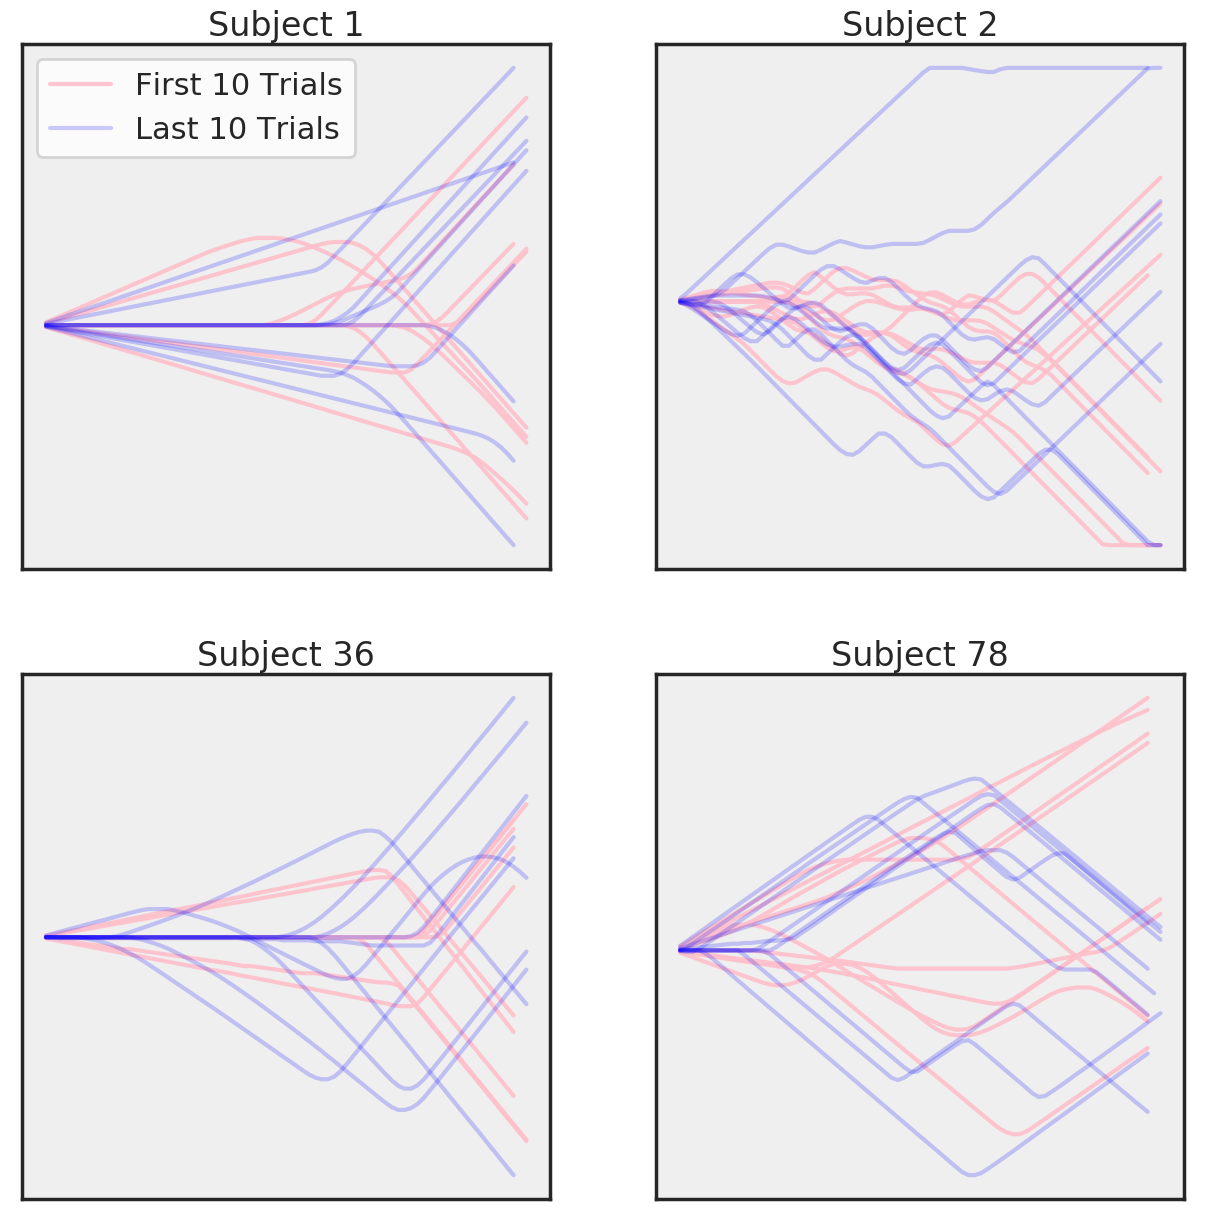

In [98]:
sns.set(style="white",context='poster', font_scale=1.0,font='arial')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,15))

#Subject 1
datasub = pickledata[pickledata['subID']==1]
ax1.set_facecolor(ps_colors[0])

for t in datasub.super_index.unique()[:10]: #for each trial
    ax1.plot(datasub[datasub.super_index==t].time, datasub[datasub.super_index==t].ball_ypos,alpha=.9, 
             color='pink')

for t in datasub.super_index.unique()[-10:]: #for each trial
    ax1.plot(datasub[datasub.super_index==t].time, datasub[datasub.super_index==t].ball_ypos,alpha=0.2, 
             color='blue')
ax1.set_yticks([]);
ax1.set_xticks([]);
ax1.set_title("Subject 1")

#Subject 2
datasub = pickledata[pickledata['subID']==2]
ax2.set_facecolor(ps_colors[0])

for t in datasub.super_index.unique()[:10]: #for each trial
    ax2.plot(datasub[datasub.super_index==t].time, datasub[datasub.super_index==t].ball_ypos,alpha=.9, 
             color='pink')

for t in datasub.super_index.unique()[-10:]: #for each trial
    ax2.plot(datasub[datasub.super_index==t].time, datasub[datasub.super_index==t].ball_ypos,alpha=0.2, 
             color='blue')
ax2.set_yticks([]);
ax2.set_xticks([]);
ax2.set_title("Subject 2")

#Subject 3
datasub = pickledata[pickledata['subID']==36]
ax3.set_facecolor(ps_colors[0])

for t in datasub.super_index.unique()[:10]: #for each trial
    ax3.plot(datasub[datasub.super_index==t].time, datasub[datasub.super_index==t].ball_ypos,alpha=.9, 
             color='pink')

for t in datasub.super_index.unique()[-10:]: #for each trial
    ax3.plot(datasub[datasub.super_index==t].time, datasub[datasub.super_index==t].ball_ypos,alpha=0.2, 
             color='blue')
ax3.set_yticks([]);
ax3.set_xticks([]);
ax3.set_title("Subject 36")

#Subject 4
datasub = pickledata[pickledata['subID']==78]
ax4.set_facecolor(ps_colors[0])

for t in datasub.super_index.unique()[:10]: #for each trial
    ax4.plot(datasub[datasub.super_index==t].time, datasub[datasub.super_index==t].ball_ypos,alpha=.9, 
             color='pink',label='First 10 Trials')

for t in datasub.super_index.unique()[-10:]: #for each trial
    ax4.plot(datasub[datasub.super_index==t].time, datasub[datasub.super_index==t].ball_ypos,alpha=0.2, 
             color='blue',label='Last 10 Trials')
ax4.set_yticks([]);
ax4.set_xticks([]);
ax4.set_title("Subject 78")
lines, labels = ax4.get_legend_handles_labels()
lines = [lines[0],lines[-1]]
labels = [labels[0],labels[-1]]
ax1.legend(lines, labels)
plt.savefig("presentationplots/firstandlast_supp.svg",bbox_inches='tight')